In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime

In [2]:
# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
import itertools

In [3]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [180]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner import RandomSearch
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

Using TensorFlow backend


In [6]:
from prophet import Prophet
# # Prophet(stan_backend="CMDSTANPY")

In [151]:
import joblib

In [7]:
import warnings

# turn off slice warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [8]:
plt.rcParams['figure.figsize'] = [12, 8]

In [9]:
store_format_df = pd.read_parquet('../Data/store_format_agg/store_format_agg.parquet')

In [10]:
store_format_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SHOP_DATE     3276 non-null   object 
 1   STORE_FORMAT  3276 non-null   object 
 2   TOTAL_QTY     3276 non-null   float64
 3   TOTAL_SPEND   3276 non-null   float64
dtypes: float64(2), object(2)
memory usage: 102.5+ KB


In [11]:
# SHOP_DATE should be a date field.
store_format_df['SHOP_DATE'] = pd.to_datetime(store_format_df['SHOP_DATE'])

In [12]:
store_format_df['SHOP_MONTH'] = store_format_df['SHOP_DATE'].dt.month_name()
store_format_df['SHOP_QUARTER'] = store_format_df['SHOP_DATE'].dt.quarter
store_format_df['SHOP_YEAR'] = store_format_df['SHOP_DATE'].dt.year

In [13]:
store_format_df = store_format_df.set_index('SHOP_DATE', drop=True).sort_index()

In [14]:
store_format_df.head()

,STORE_FORMAT,TOTAL_QTY,TOTAL_SPEND,SHOP_MONTH,SHOP_QUARTER,SHOP_YEAR
SHOP_DATE,,,,,,
2006-04-10,LS,33945.0,45132.26,April,2,2006
2006-04-10,SS,3711.0,4483.13,April,2,2006
2006-04-10,XLS,4793.0,6256.27,April,2,2006
2006-04-10,MS,10996.0,14203.70,April,2,2006
2006-04-11,SS,3396.0,3995.99,April,2,2006


In [15]:
store_format_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3276 entries, 2006-04-10 to 2008-07-06
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STORE_FORMAT  3276 non-null   object 
 1   TOTAL_QTY     3276 non-null   float64
 2   TOTAL_SPEND   3276 non-null   float64
 3   SHOP_MONTH    3276 non-null   object 
 4   SHOP_QUARTER  3276 non-null   int64  
 5   SHOP_YEAR     3276 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 179.2+ KB


In [16]:
store_format_df.head()

,STORE_FORMAT,TOTAL_QTY,TOTAL_SPEND,SHOP_MONTH,SHOP_QUARTER,SHOP_YEAR
SHOP_DATE,,,,,,
2006-04-10,LS,33945.0,45132.26,April,2,2006
2006-04-10,SS,3711.0,4483.13,April,2,2006
2006-04-10,XLS,4793.0,6256.27,April,2,2006
2006-04-10,MS,10996.0,14203.70,April,2,2006
2006-04-11,SS,3396.0,3995.99,April,2,2006


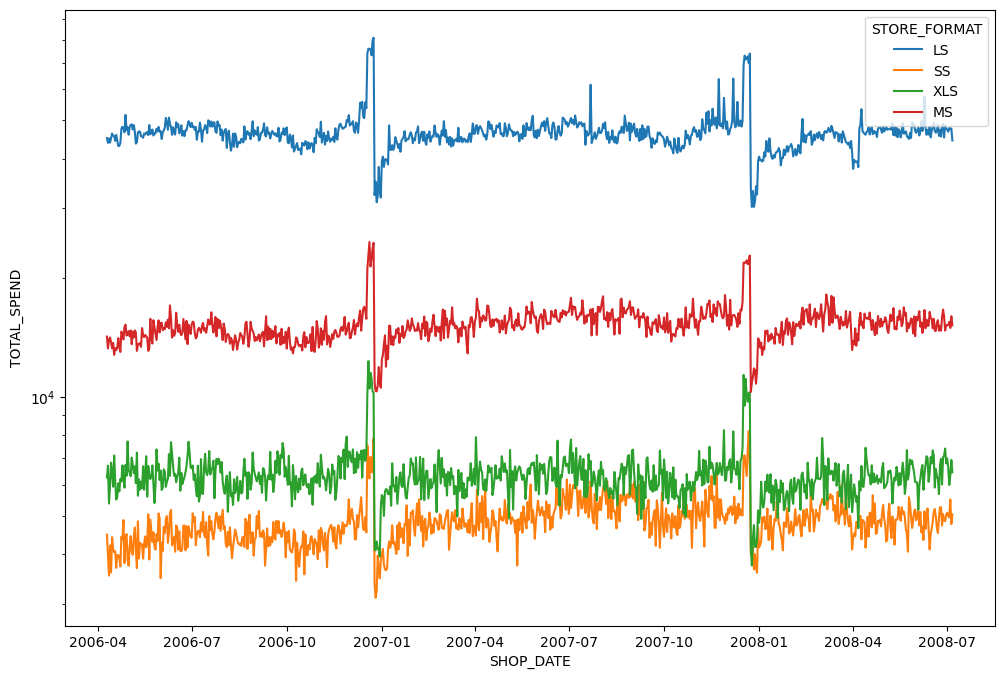

In [17]:
lp = sns.lineplot(data=store_format_df, x='SHOP_DATE', y='TOTAL_SPEND', hue='STORE_FORMAT', estimator='sum')
lp.set_yscale('log')

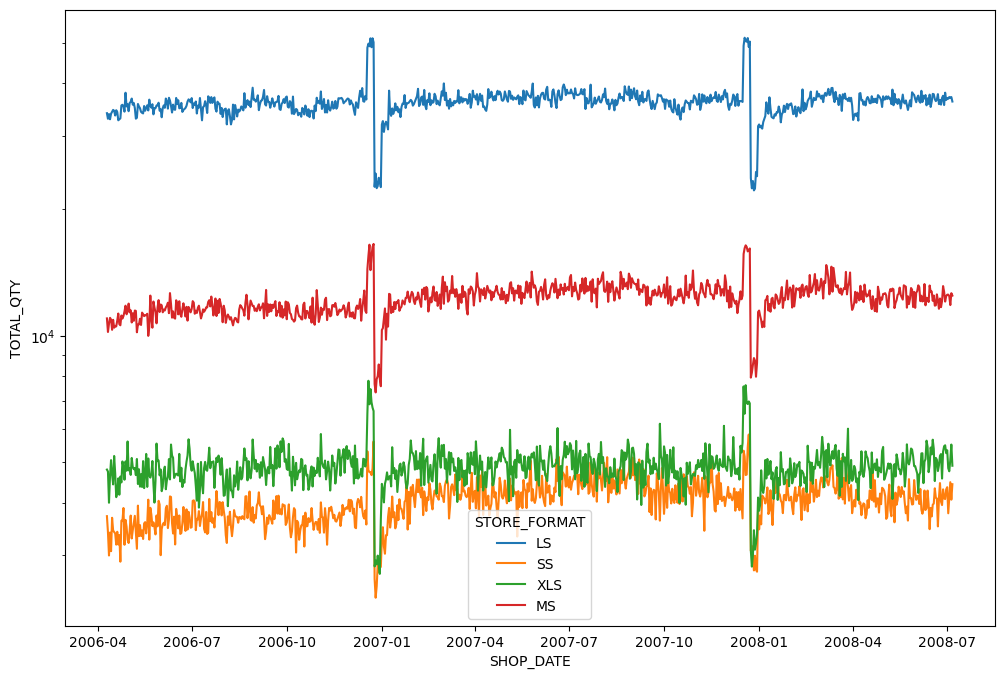

In [18]:
lp = sns.lineplot(data=store_format_df, x='SHOP_DATE', y='TOTAL_QTY', hue='STORE_FORMAT', estimator='sum')
lp.set_yscale('log')

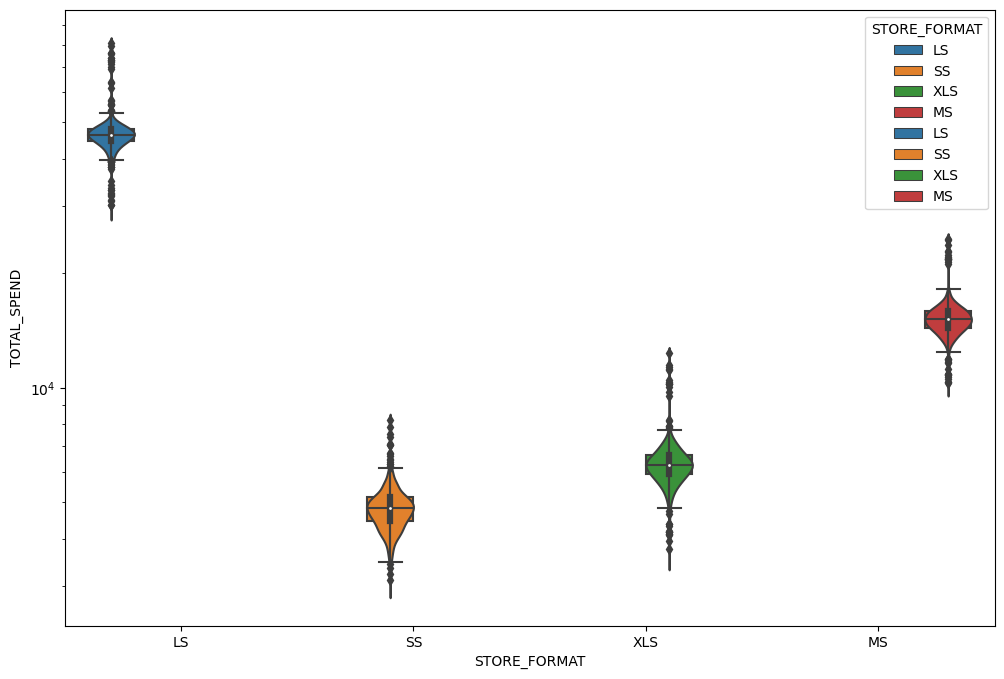

In [19]:
vp = sns.violinplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_SPEND', hue='STORE_FORMAT')
sns.boxplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_SPEND', hue='STORE_FORMAT')
vp.set_yscale('log')

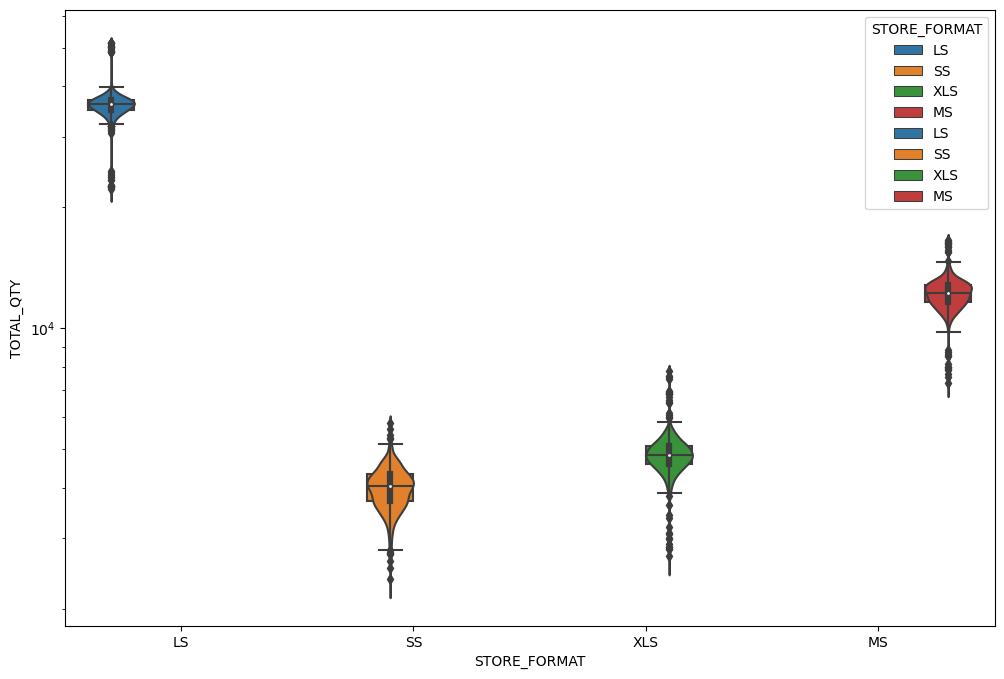

In [20]:
vp = sns.violinplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_QTY', hue='STORE_FORMAT')
sns.boxplot(data=store_format_df, x='STORE_FORMAT', y='TOTAL_QTY', hue='STORE_FORMAT')
vp.set_yscale('log')

In [21]:
# What are the different types of store format?
store_format_df['STORE_FORMAT'].unique()

array(['LS', 'SS', 'XLS', 'MS'], dtype=object)

In [22]:
def get_sorted_store_format_ts(df, format_type):
    return store_format_df.query(f"STORE_FORMAT == '{format_type}'").sort_index()

In [23]:
store_ss = get_sorted_store_format_ts(store_format_df, 'SS')
store_ms = get_sorted_store_format_ts(store_format_df, 'MS')
store_ls = get_sorted_store_format_ts(store_format_df, 'LS')
store_xls = get_sorted_store_format_ts(store_format_df, 'XLS')

In [24]:
def plot_ts_plot(df, plot_type, time_granularity):
    """
    Function to display a number of plots for a time series QTY
    """
    
    if plot_type.upper() =='LINE':
        if time_granularity.upper() == 'DATE':
            lp = sns.lineplot(data=df, x=df.index, y='TOTAL_SPEND')
        else:
            lp = sns.lineplot(data=df, x=f'SHOP_{time_granularity}', y='TOTAL_SPEND')
    elif plot_type.upper() == 'BOXPLOT':
        if time_granularity.upper() == 'DATE':
            bp = sns.boxplot(data=df, x=df.index, y='TOTAL_SPEND')
        else:
            bp = sns.boxplot(data=df, x=f'SHOP_{time_granularity}', y='TOTAL_SPEND')
    else:
        print("Unknown plot type - currently supports: 'boxplot' & 'line'")

In [25]:
def plot_ts_decomposition(df):
    """
    Function to accept a time series df and return a naive decomposition.
    """
    
    # Multiplicative Decomposition
    result_mul = seasonal_decompose(df['TOTAL_SPEND'], model='multiplicative', period=365, extrapolate_trend=len(df)) 
    # Additive Decomposition
    result_add = seasonal_decompose(df['TOTAL_SPEND'], model='additive', period=365, extrapolate_trend=len(df))

    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22) 
    result_add.plot().suptitle('Additive Decompose', fontsize=22) 
    plt.show()

In [26]:
def test_stationarity(df):
    # ADF Test
    adf_result = adfuller(df['TOTAL_SPEND'], autolag='AIC') 
    print(f'ADF Statistic: {adf_result[0]}') 
    print(f'p-value: {adf_result[1]}')
    if adf_result[1] <= 0.05:
        print("Reject Null Hypothesis, p-value <= 0.05, time series is stationary")
        adf_test = True
    else:
        print("Fail to reject Null Hypothesis, p-value > 0.05, time series is non-stationary")
        adf_test= False
    for key, value in adf_result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')
        
    # KPSS Test
    kpss_result = kpss(df['TOTAL_SPEND'], regression='c') 
    print('\nKPSS Statistic: %f' % kpss_result[0]) 
    print('p-value: %f' % kpss_result[1])
    if kpss_result[1] > 0.05:
        print("Reject Null Hypothesis, p-value > 0.05, time series is stationary")
        kpss_test = False
    else:
        print("Fail to reject Null Hypothesis, p-value <= 0.05, time series is non-stationary")
        kpss_test = True
    for key, value in kpss_result[3].items():
        print('Critial Values:')
        print(f'{key}, {value}')
        
        
    if adf_test and kpss_test:
        print("Both test indicate a stationary time series")
    elif not adf_test and not kpss_test:
        print("Neither test indicates a stationary time series")
    elif not adf_test and kpss_test:
        print("TS appears to be trend stationary, consider detrending the overall.")
    else:
        print("TS appears to be difference stationary, consider differencing the overall")

In [27]:
test_stationarity(store_xls)

ADF Statistic: -10.026000872408982
p-value: 1.6314719537350395e-17
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4384289321263126
Critial Values:
5%, -2.865105979079729
Critial Values:
10%, -2.568668841575869

KPSS Statistic: 0.102118
p-value: 0.100000
Reject Null Hypothesis, p-value > 0.05, time series is stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
TS appears to be difference stationary, consider differencing the overall


C:\Users\emers\AppData\Local\Temp\ipykernel_824\3243011022.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df['TOTAL_SPEND'], regression='c')


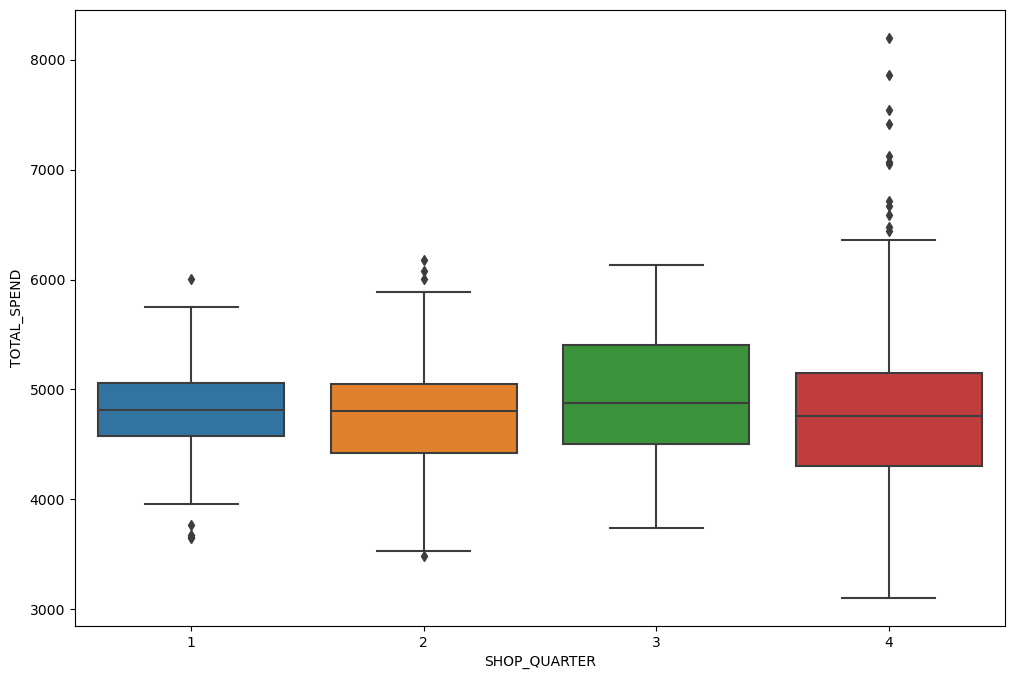

In [28]:
plot_ts_plot(store_ss, 'boxplot', 'QUARTER')

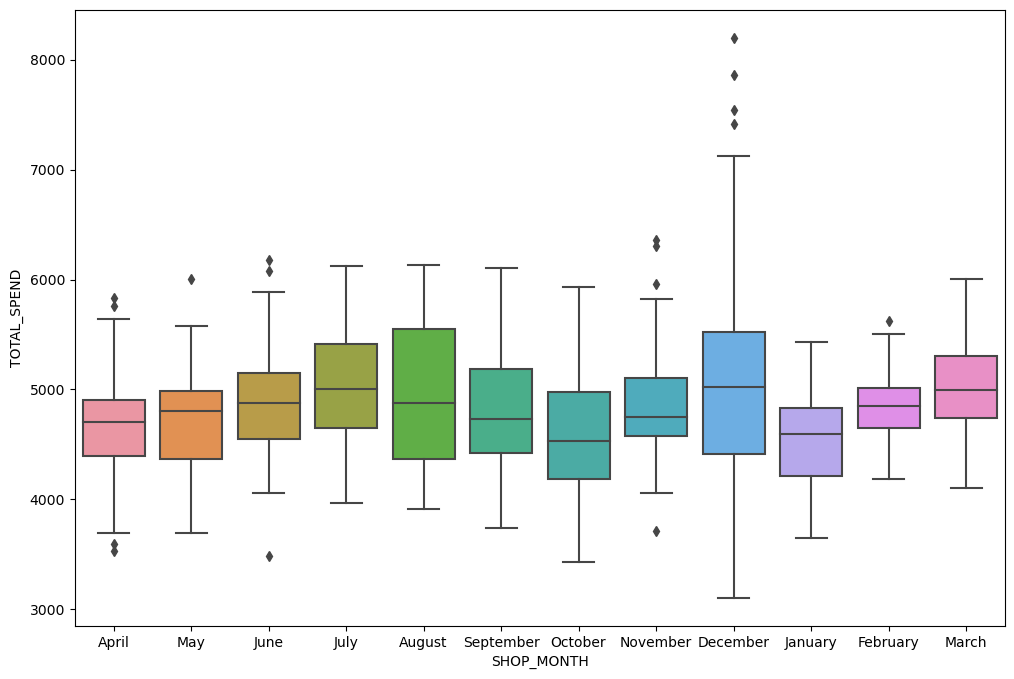

In [29]:
plot_ts_plot(store_ss, 'boxplot', 'MONTH')

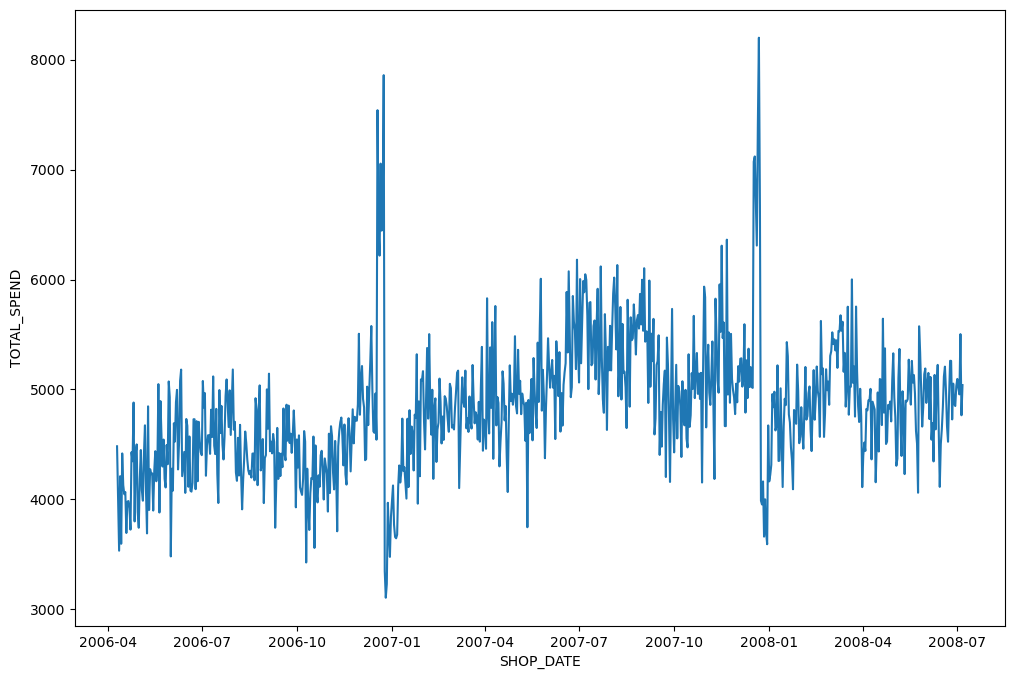

In [30]:
plot_ts_plot(store_ss, 'line', 'DATE')

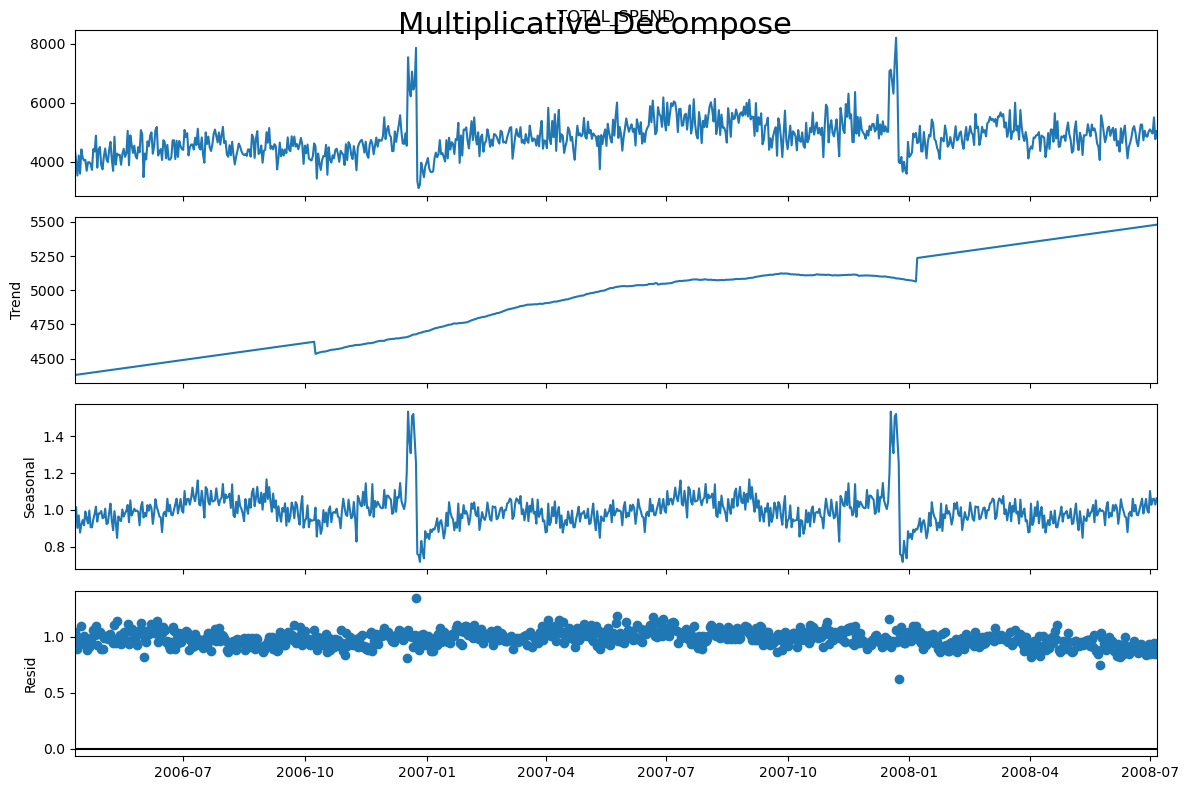

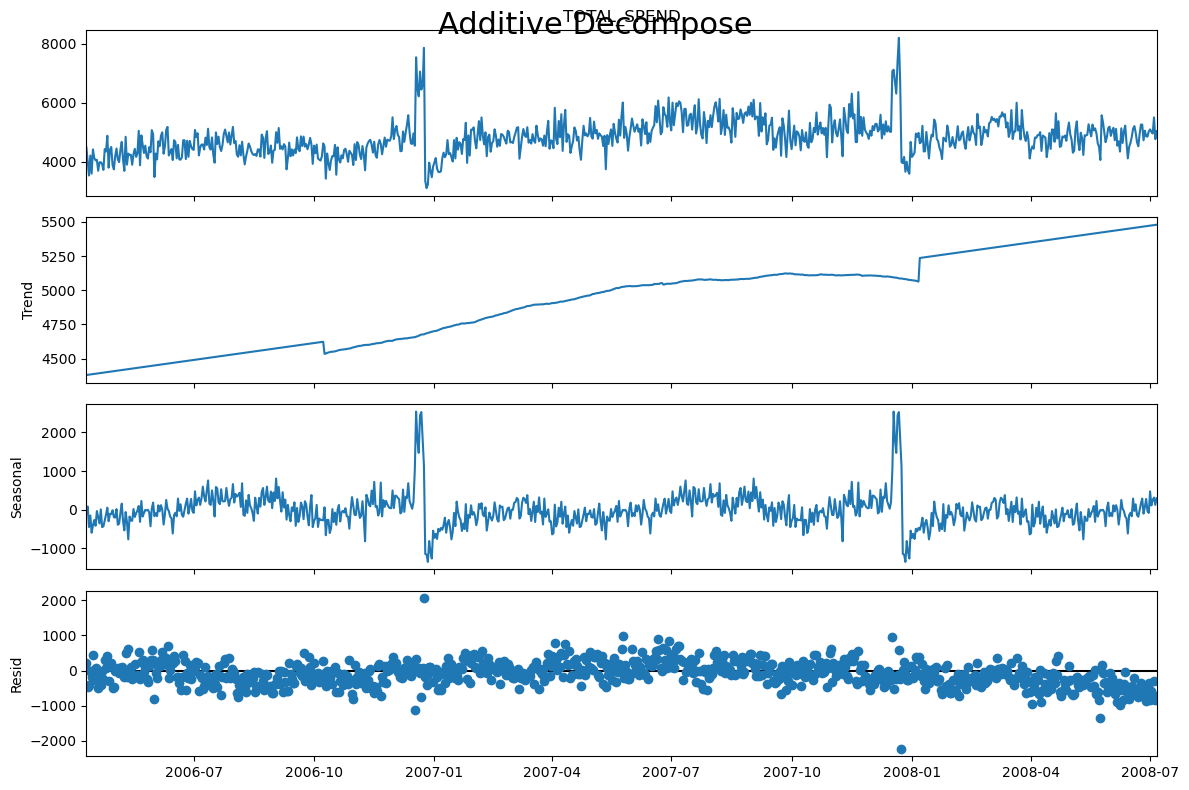

In [31]:
plot_ts_decomposition(store_ss)

SS appears to stationary with a 12 months seasonal component.<br>
No action necessary in pre-processing.

In [32]:
test_stationarity(store_ss)

ADF Statistic: -5.097661179892832
p-value: 1.4171600607797829e-05
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4384589869479023
Critial Values:
5%, -2.8651192271940693
Critial Values:
10%, -2.5686758988725416

KPSS Statistic: 2.070406
p-value: 0.010000
Fail to reject Null Hypothesis, p-value <= 0.05, time series is non-stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
Both test indicate a stationary time series


C:\Users\emers\AppData\Local\Temp\ipykernel_824\3243011022.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['TOTAL_SPEND'], regression='c')


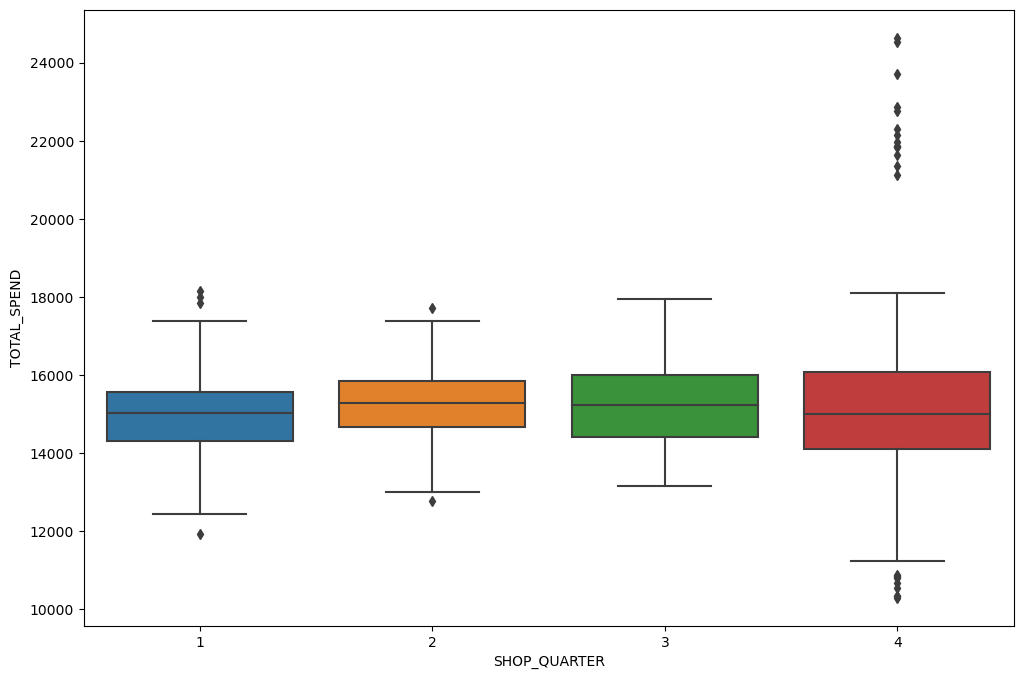

In [33]:
plot_ts_plot(store_ms, 'boxplot', 'QUARTER')

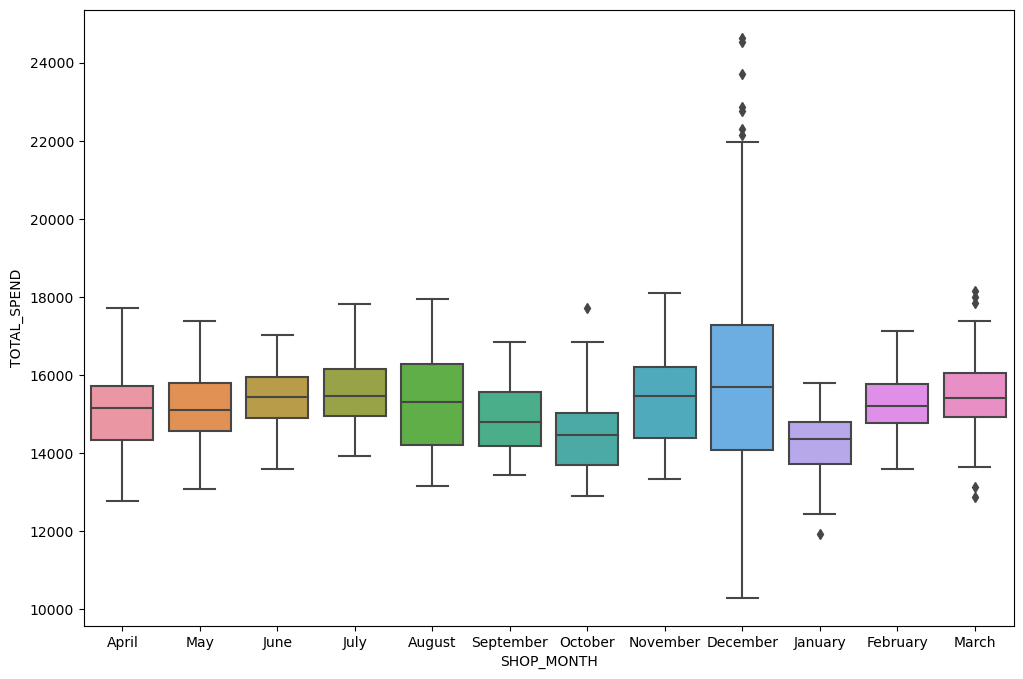

In [34]:
plot_ts_plot(store_ms, 'boxplot', 'MONTH')

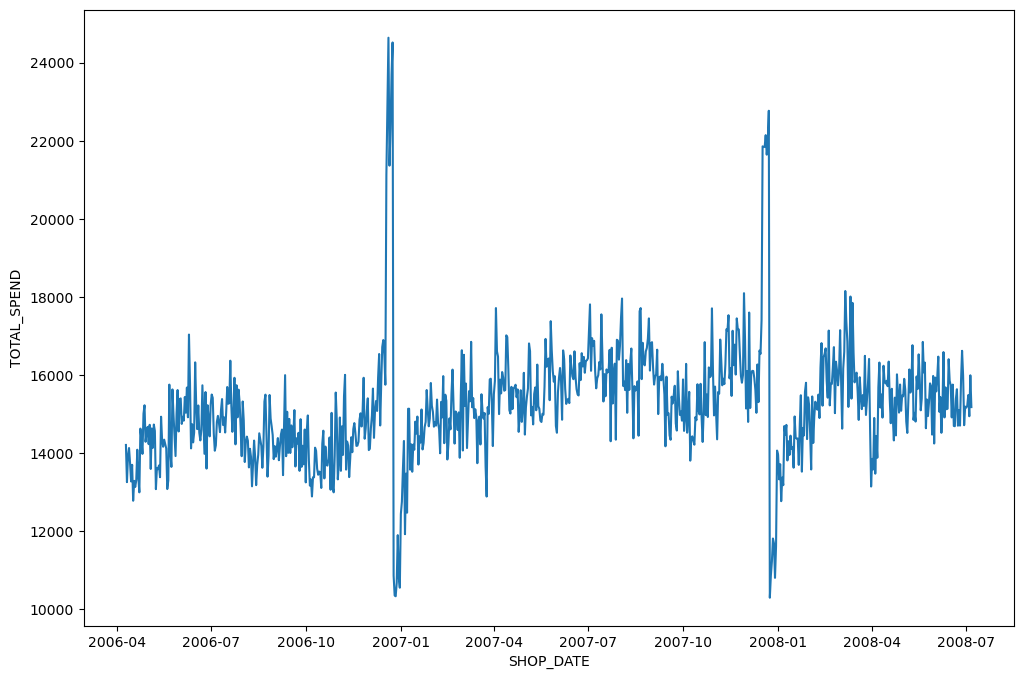

In [35]:
plot_ts_plot(store_ms, 'line', 'DATE')

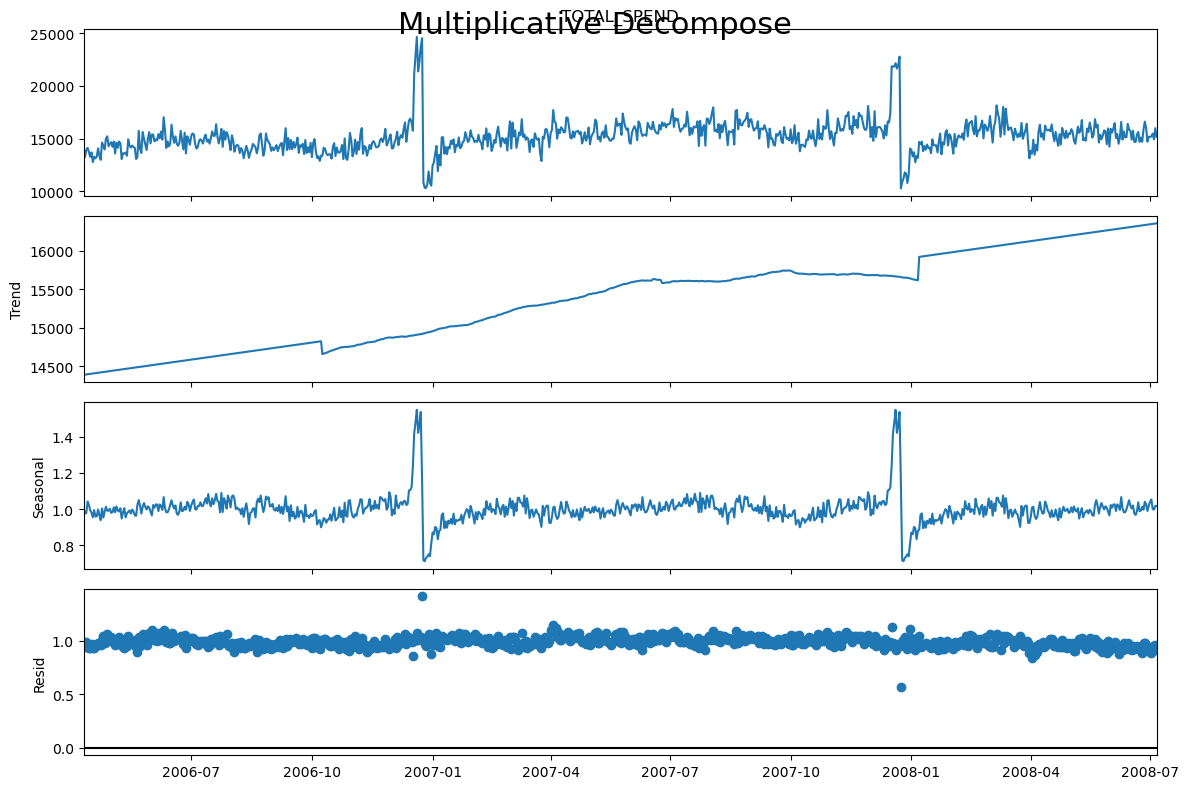

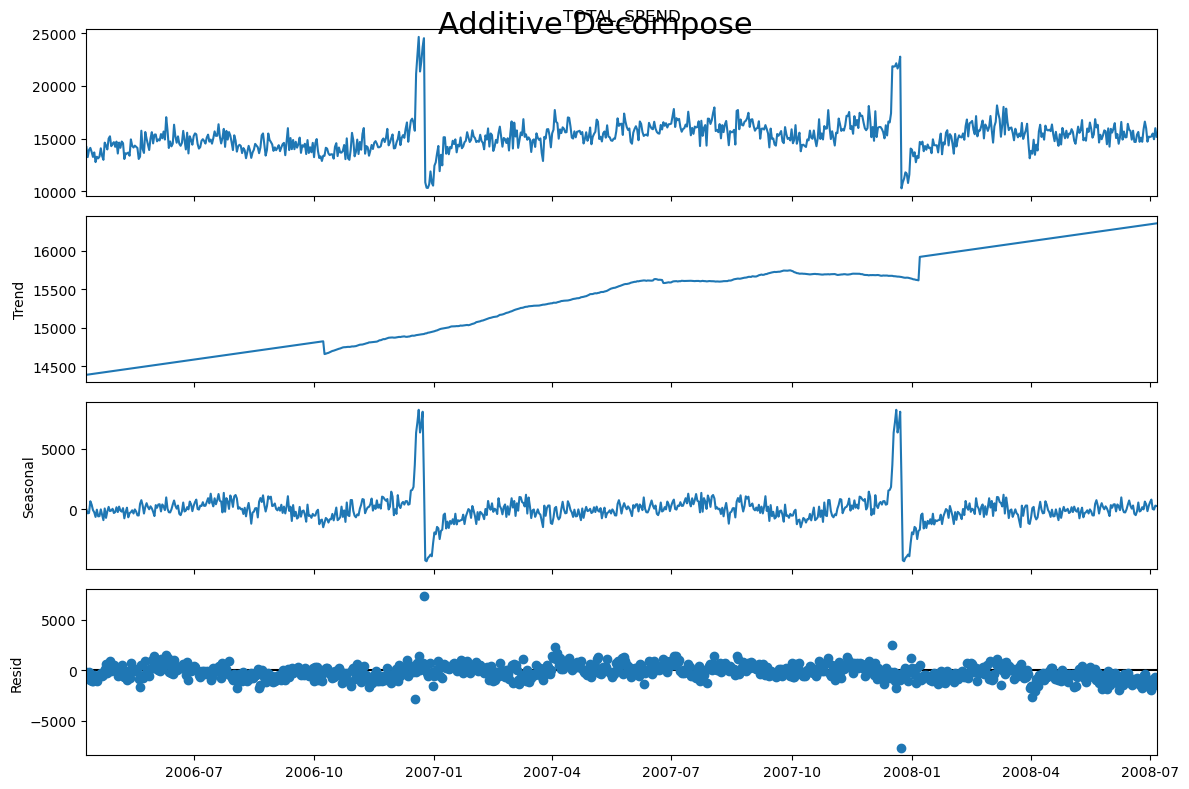

In [36]:
plot_ts_decomposition(store_ms)

MS appears to stationary with a 12 months seasonal component.<br>
No action necessary in pre-processing.

In [37]:
test_stationarity(store_ms)

ADF Statistic: -6.907015321135649
p-value: 1.2397847854926307e-09
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.438448943858302
Critial Values:
5%, -2.8651148002318227
Critial Values:
10%, -2.568673540618808

KPSS Statistic: 1.307488
p-value: 0.010000
Fail to reject Null Hypothesis, p-value <= 0.05, time series is non-stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
Both test indicate a stationary time series


C:\Users\emers\AppData\Local\Temp\ipykernel_824\3243011022.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['TOTAL_SPEND'], regression='c')


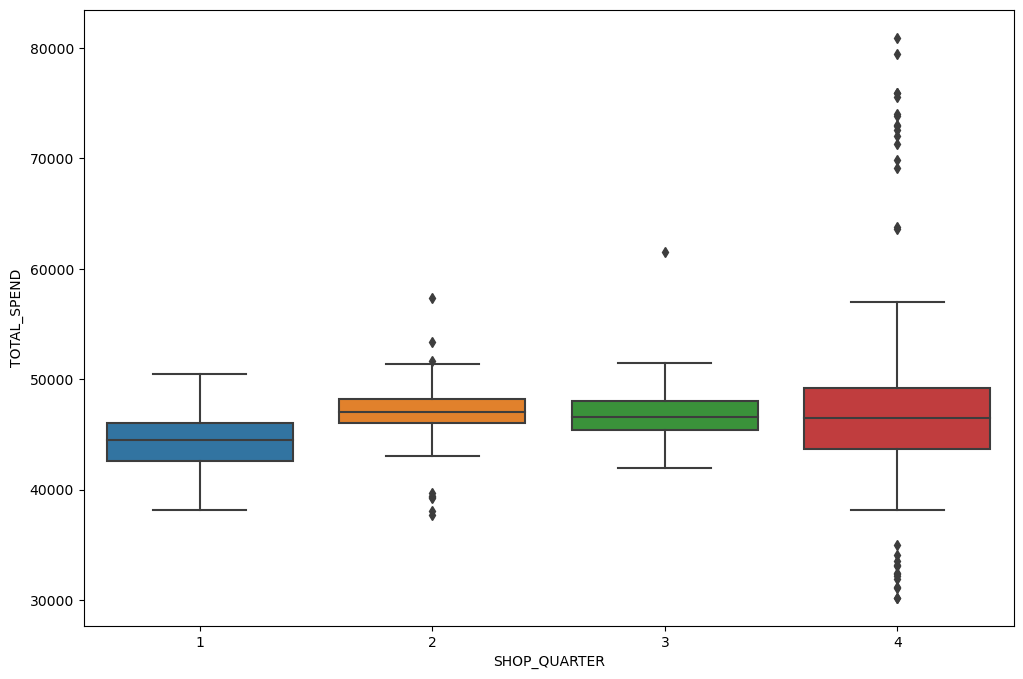

In [38]:
plot_ts_plot(store_ls, 'boxplot', 'QUARTER')

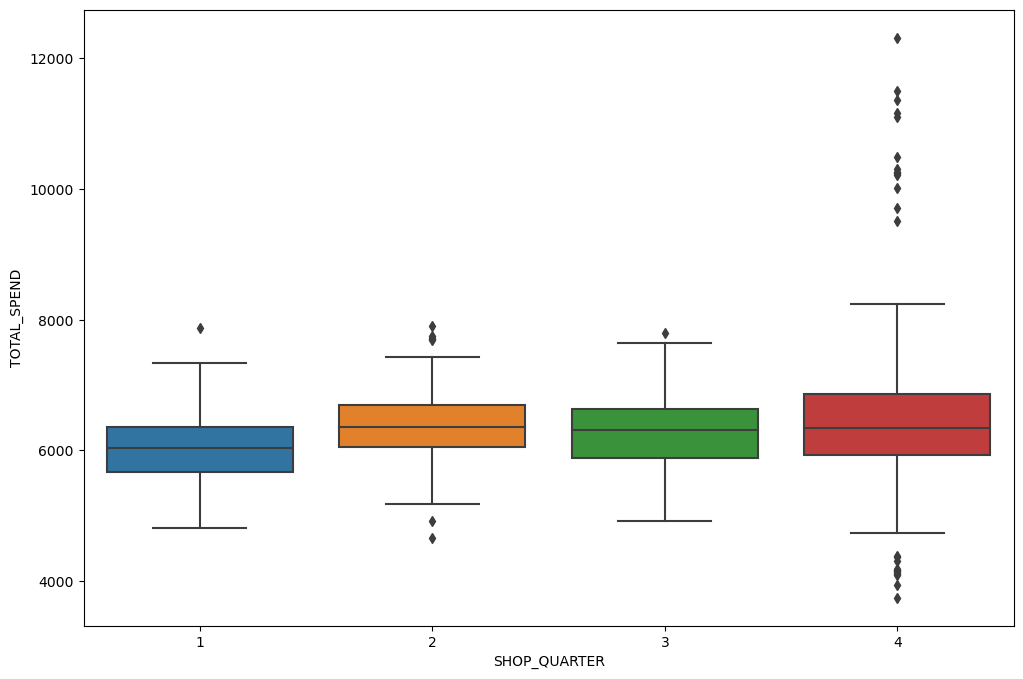

In [39]:
plot_ts_plot(store_xls, 'boxplot', 'QUARTER')

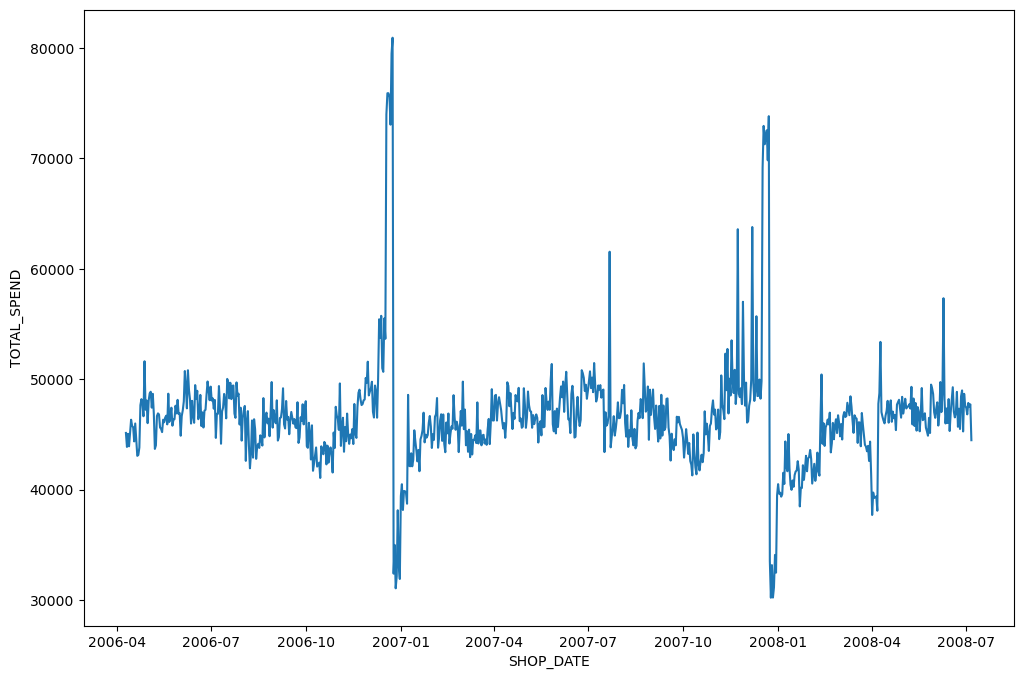

In [40]:
plot_ts_plot(store_ls, 'line', 'DATE')

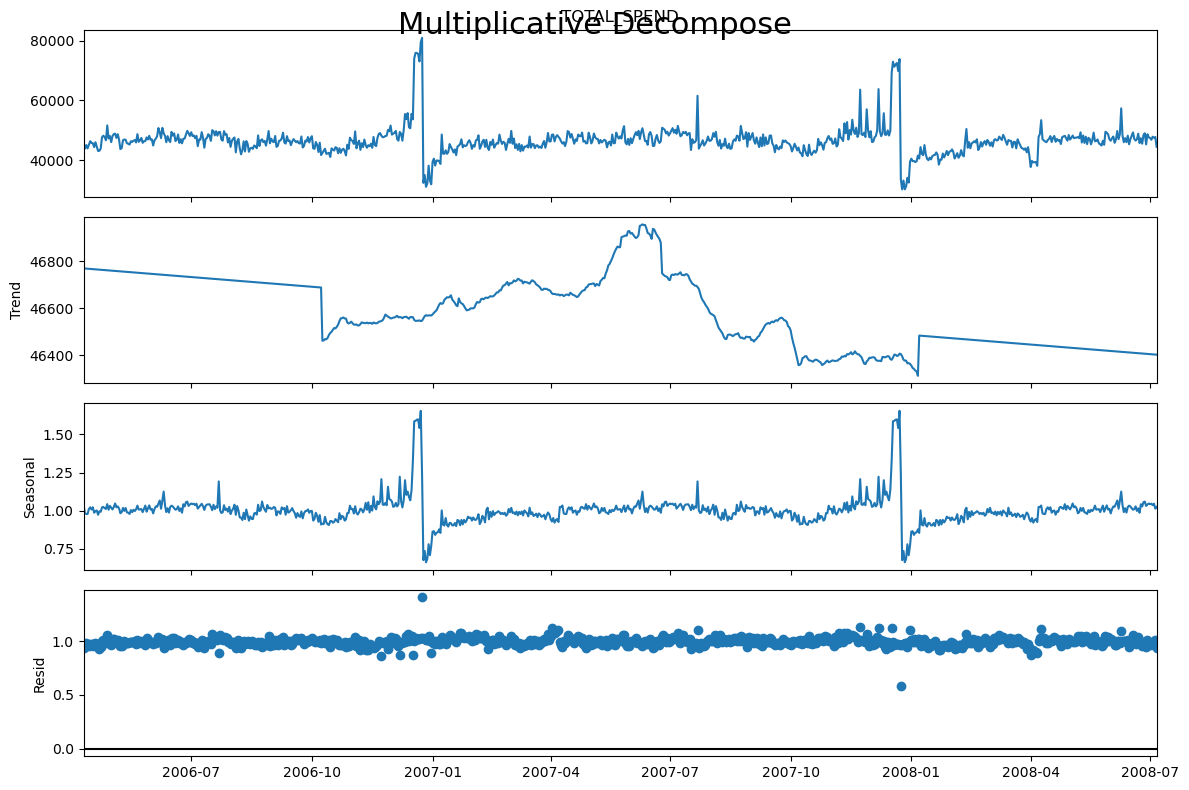

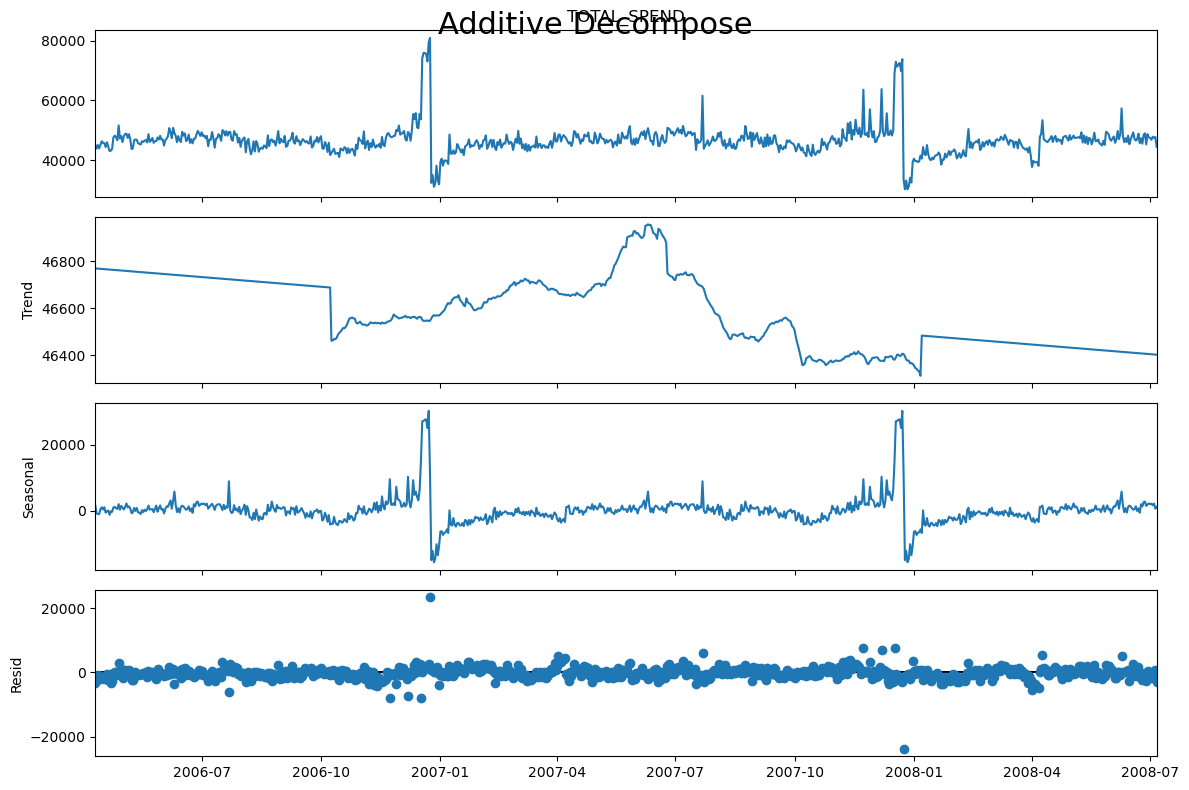

In [41]:
plot_ts_decomposition(store_ls)

LS appears to difference stationary with a 12 months seasonal component.<br>
Its unnecessary to remove seasonality or to de-trend the time series as Auto ARIMA will take care of that.

In [42]:
test_stationarity(store_ls)

ADF Statistic: -5.6625703025125835
p-value: 9.307242380693076e-07
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4385197724757233
Critial Values:
5%, -2.8651460209504114
Critial Values:
10%, -2.5686901720199313

KPSS Statistic: 0.044626
p-value: 0.100000
Reject Null Hypothesis, p-value > 0.05, time series is stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
TS appears to be difference stationary, consider differencing the overall


C:\Users\emers\AppData\Local\Temp\ipykernel_824\3243011022.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df['TOTAL_SPEND'], regression='c')


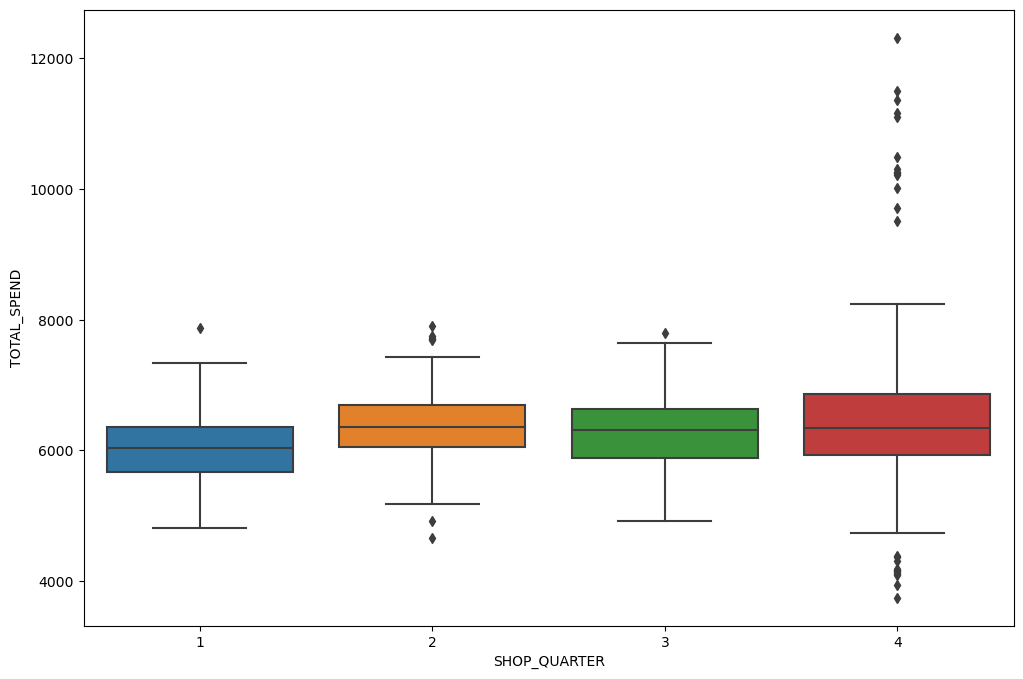

In [43]:
plot_ts_plot(store_xls, 'boxplot', 'QUARTER')

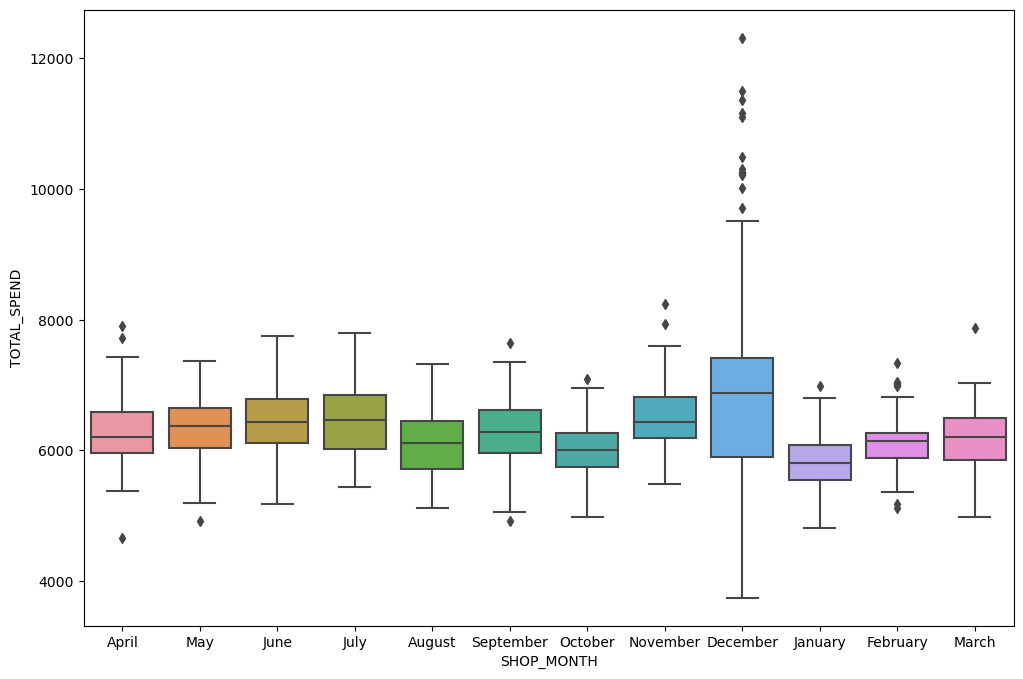

In [44]:
plot_ts_plot(store_xls, 'boxplot', 'MONTH')

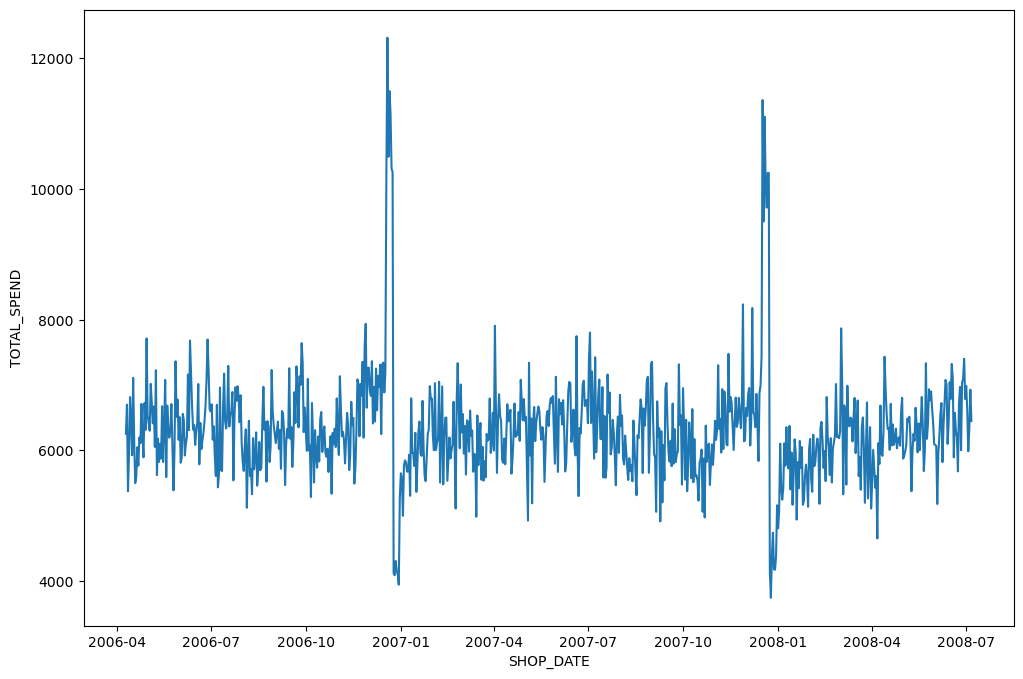

In [45]:
plot_ts_plot(store_xls, 'line', 'DATE')

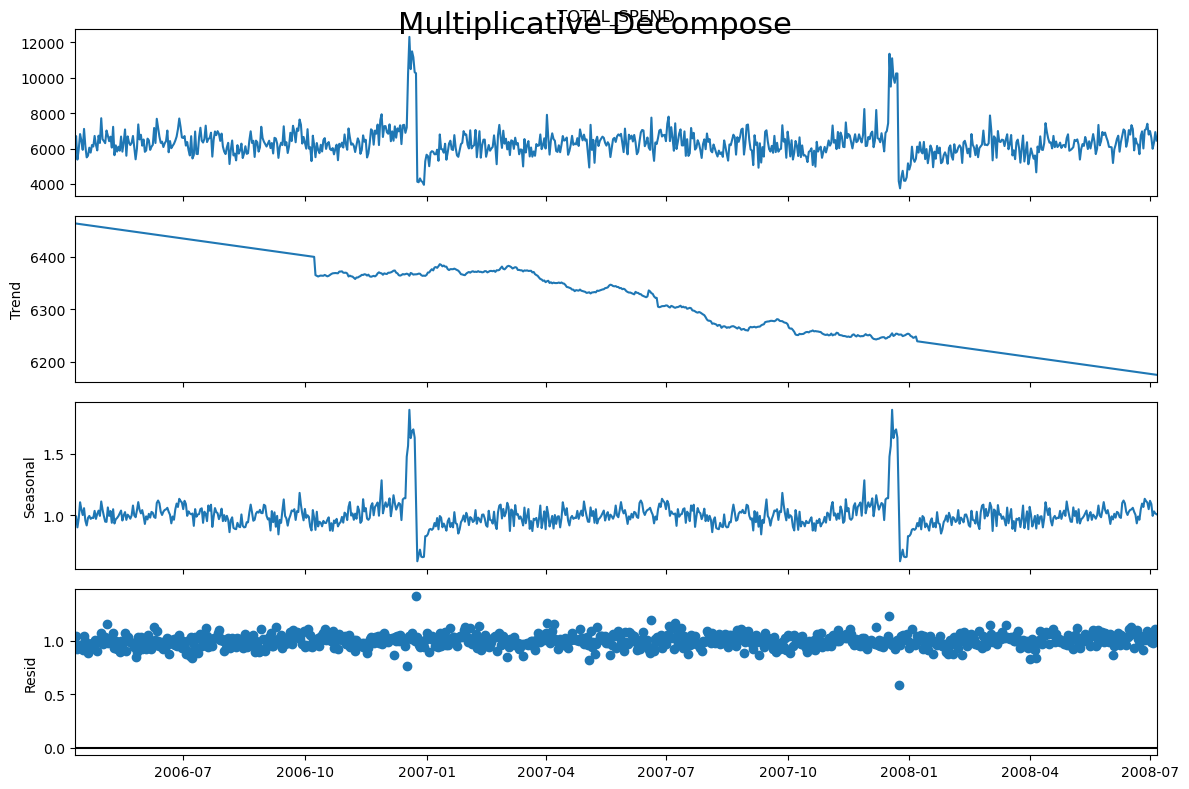

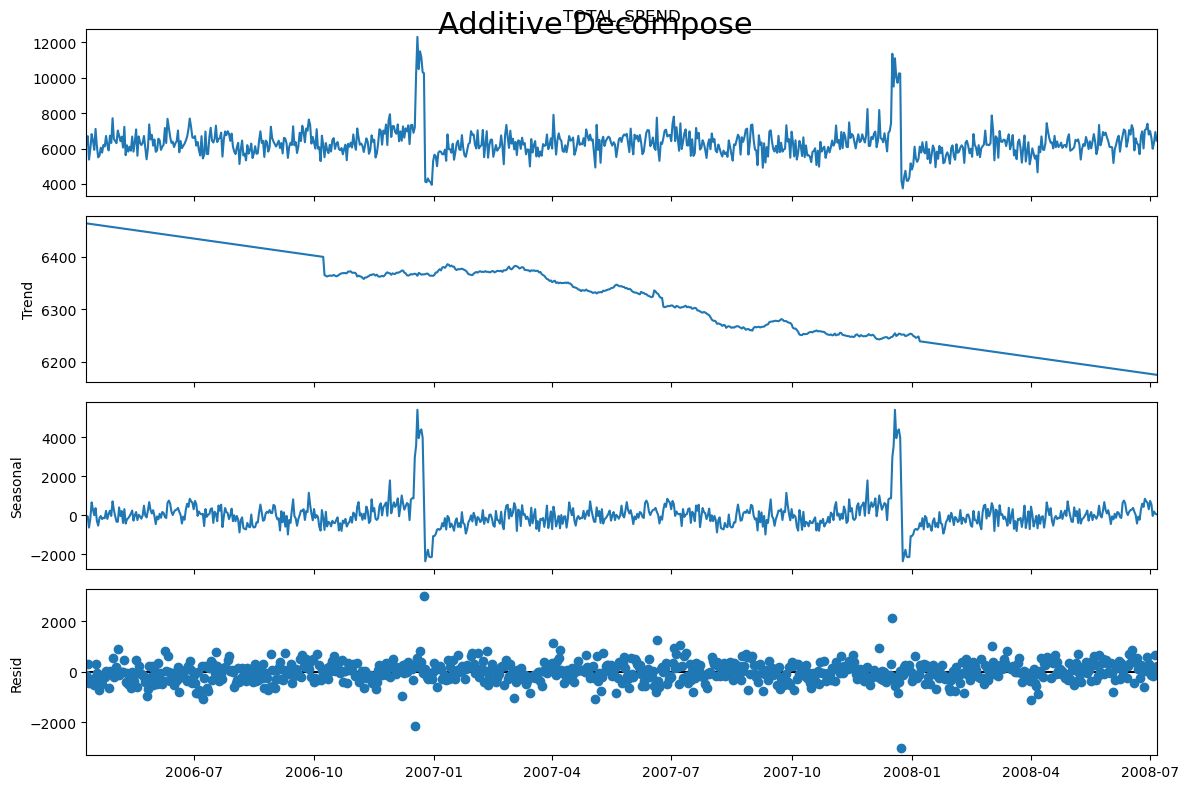

In [46]:
plot_ts_decomposition(store_xls)

XLS appears to difference stationary with a 12 months seasonal component.<br>
Its unnecessary to remove seasonality or to de-trend the time series as Auto ARIMA will take care of that.

In [47]:
test_stationarity(store_xls)

ADF Statistic: -10.026000872408982
p-value: 1.6314719537350395e-17
Reject Null Hypothesis, p-value <= 0.05, time series is stationary
Critial Values:
1%, -3.4384289321263126
Critial Values:
5%, -2.865105979079729
Critial Values:
10%, -2.568668841575869

KPSS Statistic: 0.102118
p-value: 0.100000
Reject Null Hypothesis, p-value > 0.05, time series is stationary
Critial Values:
10%, 0.347
Critial Values:
5%, 0.463
Critial Values:
2.5%, 0.574
Critial Values:
1%, 0.739
TS appears to be difference stationary, consider differencing the overall


C:\Users\emers\AppData\Local\Temp\ipykernel_824\3243011022.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df['TOTAL_SPEND'], regression='c')


### Dataset Preparation

In [48]:
# Create dataset from store format df with lagged values looking back 1 year
def create_training_dataset(data, look_back=365):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data.iloc[i:(i+look_back), 0]
        X.append(a)
        Y.append(data.iloc[i + look_back, 0])
    
    return [np.array(X), np.array(Y)]

In [49]:
def create_prediction_dataset(data, look_back=365):
    final_predict_set = data.iloc[len(data)-look_back-90: len(data)-90]
    final_test_set = data.iloc[len(data)-90:]
    
    return final_predict_set, final_test_set

In [50]:
def get_min_max_scaler(data):
    """
    Function to take in a series, fit a min_max scaler and return.
    This will be used to normalise the time series data before then reverse the prediction values
    to help reduce the loss error.
    We will fit across the entire dataset to accurately reverse the transformation later.
    """
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(data)
    return min_max_scaler
    

In [51]:
def apply_min_max_scaling(np_array, scaler):
    return scaler.transform(np_array)

In [52]:
def reverse_min_max_scaling(np_array, scaler):
    np_array = np.array(np_array)
    return scaler.inverse_transform(np_array.reshape(1, -1))

In [53]:
def print_dataset_dims(dataset, dataset_name):
    print(f"# of dataframes for {dataset_name}: {len(dataset)}")
    print(f"# of observations: {len(dataset[0])}")
    print(f"# of observations per row: {len(dataset[0][0])}")
    print(f"# of target values: {len(dataset[1])}")
    print(f"# of target values per row: {len([dataset[1][0]])}")

In [54]:
store_ss_ts_min_max_scaler = get_min_max_scaler(store_ss[['TOTAL_SPEND']])
store_ss['TOTAL_SPEND_SCALED'] = store_ss_ts_min_max_scaler.transform(np.array(store_ss['TOTAL_SPEND']).reshape(-1,1))
store_ss_ts_train = create_training_dataset(store_ss[['TOTAL_SPEND']], 365)
store_ss_ts_train_scaled = create_training_dataset(store_ss[['TOTAL_SPEND_SCALED']], 365)

C:\Users\emers\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [55]:
store_ms_ts_min_max_scaler = get_min_max_scaler(store_ms[['TOTAL_SPEND']])
store_ms['TOTAL_SPEND_SCALED'] = store_ms_ts_min_max_scaler.transform(np.array(store_ms['TOTAL_SPEND']).reshape(-1,1))
store_ms_ts_train = create_training_dataset(store_ms[['TOTAL_SPEND']], 365)
store_ms_ts_train_scaled = create_training_dataset(store_ms[['TOTAL_SPEND_SCALED']], 365)

C:\Users\emers\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [56]:
store_ls_ts_min_max_scaler = get_min_max_scaler(store_ls[['TOTAL_SPEND']])
store_ls['TOTAL_SPEND_SCALED'] = store_ls_ts_min_max_scaler.transform(np.array(store_ls['TOTAL_SPEND']).reshape(-1,1))
store_ls_ts_train = create_training_dataset(store_ls[['TOTAL_SPEND']], 365)
store_ls_ts_train_scaled = create_training_dataset(store_ls[['TOTAL_SPEND_SCALED']], 365)

C:\Users\emers\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [57]:
store_xls_ts_min_max_scaler = get_min_max_scaler(store_xls[['TOTAL_SPEND']])
store_xls['TOTAL_SPEND_SCALED'] = store_xls_ts_min_max_scaler.transform(np.array(store_xls['TOTAL_SPEND']).reshape(-1,1))
store_xls_ts_train = create_training_dataset(store_xls[['TOTAL_SPEND']], 365)
store_xls_ts_train_scaled = create_training_dataset(store_xls[['TOTAL_SPEND_SCALED']], 365)

C:\Users\emers\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [58]:
store_ss_ts_pred = create_prediction_dataset(store_ss[['TOTAL_SPEND']], 365)
store_ms_ts_pred = create_prediction_dataset(store_ms[['TOTAL_SPEND']], 365)
store_ls_ts_pred = create_prediction_dataset(store_ls[['TOTAL_SPEND']], 365)
store_xls_ts_pred = create_prediction_dataset(store_xls[['TOTAL_SPEND']], 365)

In [59]:
store_ss_ts_pred_scaled = create_prediction_dataset(store_ss[['TOTAL_SPEND_SCALED']], 365)
store_ms_ts_pred_scaled = create_prediction_dataset(store_ms[['TOTAL_SPEND_SCALED']], 365)
store_ls_ts_pred_scaled = create_prediction_dataset(store_ls[['TOTAL_SPEND_SCALED']], 365)
store_xls_ts_pred_scaled = create_prediction_dataset(store_xls[['TOTAL_SPEND_SCALED']], 365)

### All sets of observations contain 638 rows with a lag of 180 days

In [60]:
print_dataset_dims(store_ss_ts_train, "SS Stores")

# of dataframes for SS Stores: 2
# of observations: 453
# of observations per row: 365
# of target values: 453
# of target values per row: 1


In [61]:
print_dataset_dims(store_ms_ts_train, "MS Stores")

# of dataframes for MS Stores: 2
# of observations: 453
# of observations per row: 365
# of target values: 453
# of target values per row: 1


In [62]:
print_dataset_dims(store_ls_ts_train, "LS Stores")

# of dataframes for LS Stores: 2
# of observations: 453
# of observations per row: 365
# of target values: 453
# of target values per row: 1


In [63]:
print_dataset_dims(store_xls_ts_train, "XLS Stores")

# of dataframes for XLS Stores: 2
# of observations: 453
# of observations per row: 365
# of target values: 453
# of target values per row: 1


# Splitting into train and test

In [64]:
def get_train_and_test_data(dataset):
    X = dataset[0]
    y = dataset[1]

    # Splitting data 80/20 for train and test
    train_size = int(len(X) - 90)
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size], y[train_size:]
    
    return train_X, test_X, train_y, test_y

In [65]:
store_ss_train_X, store_ss_test_X, store_ss_train_y, store_ss_test_y = get_train_and_test_data(store_ss_ts_train)
store_ms_train_X, store_ms_test_X, store_ms_train_y, store_ms_test_y = get_train_and_test_data(store_ms_ts_train)
store_ls_train_X, store_ls_test_X, store_ls_train_y, store_ls_test_y = get_train_and_test_data(store_ls_ts_train)
store_xls_train_X, store_xls_test_X, store_xls_train_y, store_xls_test_y = get_train_and_test_data(store_xls_ts_train)

In [66]:
store_ss_train_X_s, store_ss_test_X_s, store_ss_train_y_s, store_ss_test_y_s = get_train_and_test_data(store_ss_ts_train_scaled)
store_ms_train_X_s, store_ms_test_X_s, store_ms_train_y_s, store_ms_test_y_s = get_train_and_test_data(store_ms_ts_train_scaled)
store_ls_train_X_s, store_ls_test_X_s, store_ls_train_y_s, store_ls_test_y_s = get_train_and_test_data(store_ls_ts_train_scaled)
store_xls_train_X_s, store_xls_test_X_s, store_xls_train_y_s, store_xls_test_y_s = get_train_and_test_data(store_xls_ts_train_scaled)

# Naive forecast using 365 day lag

In [269]:
def evaluate_naive_forecast(naive_forecast, test_data):
    print("30 Day")
    evaluate_model_predictions(naive_forecast['TOTAL_SPEND'].values[:30], test_data['TOTAL_SPEND'].values[:30])
    print("60 Day")
    evaluate_model_predictions(naive_forecast['TOTAL_SPEND'].values[:60], test_data['TOTAL_SPEND'].values[:60])
    print("90 Day")
    evaluate_model_predictions(naive_forecast['TOTAL_SPEND'].values[:90], test_data['TOTAL_SPEND'].values[:90])

In [178]:
start_window = 365 + 90 + 1
end_window = 365+1
naive_ss = store_ss[['TOTAL_SPEND']].iloc[-start_window:-end_window]
naive_ms = store_ms[['TOTAL_SPEND']].iloc[-start_window:-end_window]
naive_ls = store_ls[['TOTAL_SPEND']].iloc[-start_window:-end_window]
naive_xls = store_xls[['TOTAL_SPEND']].iloc[-start_window:-end_window]

In [270]:
evaluate_naive_forecast(naive_ss, store_ss[['TOTAL_SPEND']].iloc[len(store_ss)-90:])

30 Day
MSE: 233171.7843533334
MAE: 365.6126666666667
RMSE: 482.87864350510824
60 Day
MSE: 239759.93615833332
MAE: 372.7238333333334
RMSE: 489.6528731237399
90 Day
MSE: 292124.8527955555
MAE: 411.3886666666666
RMSE: 540.4857563299475


In [271]:
evaluate_naive_forecast(naive_ms, store_ms[['TOTAL_SPEND']].iloc[len(store_ms)-90:])

30 Day
MSE: 880522.5975366671
MAE: 793.795666666667
RMSE: 938.3616560456139
60 Day
MSE: 897824.839976667
MAE: 783.455
RMSE: 947.5361945470299
90 Day
MSE: 1020597.602374445
MAE: 824.7047777777778
RMSE: 1010.2463077757052


In [272]:
evaluate_naive_forecast(naive_ls, store_ls[['TOTAL_SPEND']].iloc[len(store_ls)-90:])

30 Day
MSE: 4088678.905040002
MAE: 1553.1699999999996
RMSE: 2022.048195528485
60 Day
MSE: 4778942.640296666
MAE: 1762.4460000000001
RMSE: 2186.0792849978397
90 Day
MSE: 5904297.983155554
MAE: 1945.528222222222
RMSE: 2429.8761250639


In [273]:
evaluate_naive_forecast(naive_xls, store_xls[['TOTAL_SPEND']].iloc[len(store_xls)-90:])

30 Day
MSE: 292424.3589066666
MAE: 422.48599999999993
RMSE: 540.7627565824653
60 Day
MSE: 319357.87821333326
MAE: 437.94566666666657
RMSE: 565.1175791048561
90 Day
MSE: 380041.19179444446
MAE: 484.93877777777766
RMSE: 616.4748103486828


# Exponential Smoothing Baseline

In [244]:
def train_exp_smooth_model(training_data, test_data, look_forward):
    
    best_mse = float('inf')
    best_params = {'alpha': None, 'beta': None, 'gamma': None}
    # Grid Search
    for alpha in [0.1, 0.2, 0.5, 0.9]:
        for beta in [0.1, 0.2, 0.5, 0.9]:
            for gamma in [0.1, 0.2, 0.5, 0.9]:
                exp_model = ExponentialSmoothing(training_data, trend='add', seasonal='add')
                exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
                exp_predictions = exp_model_fit.forecast(steps=look_forward)
                if np.any(np.isnan(exp_predictions)):
                    continue
                mse = mean_squared_error(test_data, exp_predictions, )
                if mse < best_mse:
                    best_mse = mse
                    best_params['alpha'] = alpha
                    best_params['beta'] = beta
                    best_params['gamma'] = gamma
    print(f"Best MSE: {best_mse}")
    print(f"Best Params: {best_params}")
    return exp_model.fit(smoothing_level=best_params['alpha'], 
                         smoothing_slope=best_params['beta'], 
                         smoothing_seasonal=best_params['gamma'])

In [232]:
def predict_exp_smooth(model, look_forward):
    return model.forecast(steps=look_forward)

In [233]:
def evaluate_exp_smooth_model(exp_train, exp_test):
    exp_model = train_exp_smooth_model(exp_train, exp_test, 90)
    
    exp_model_predict_30 = predict_exp_smooth(exp_model, 30)
    exp_model_predict_60 = predict_exp_smooth(exp_model, 60)
    exp_model_predict_90 = predict_exp_smooth(exp_model, 90)

    exp_test_30 = exp_test.iloc[:30]
    exp_test_60 = exp_test.iloc[:60]
    exp_test_90 = exp_test.iloc[:90]

    evaluate_model_predictions(exp_test_30, exp_model_predict_30)
    evaluate_model_predictions(exp_test_60, exp_model_predict_60)
    evaluate_model_predictions(exp_test_90, exp_model_predict_90)
    
    return exp_model, exp_model_predict_30, exp_model_predict_60, exp_model_predict_90

In [234]:
exp_train_ss = store_ss[['TOTAL_SPEND']].iloc[:len(store_ss)-90]
exp_test_ss = store_ss[['TOTAL_SPEND']].iloc[len(store_ss)-90:]
exp_model_ss, exp_ss_30_p, exp_ss_60_p, exp_ss_90_p = evaluate_exp_smooth_model(exp_train_ss, exp_test_ss)

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinte

Best MSE: 134490.62564674197
Best Params: {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.1}
MSE: 135339.57421936162
MAE: 307.71095367084
RMSE: 367.88527317543117
MSE: 131790.4111751712
MAE: 285.1709055281441
RMSE: 363.02949077887763
MSE: 134490.62564674197
MAE: 288.58182437774127
RMSE: 366.7296356264952


C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:20: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  return exp_model.fit(smoot

In [245]:
exp_train_ms = store_ms[['TOTAL_SPEND']].iloc[:len(store_ms)-90]
exp_test_ms = store_ms[['TOTAL_SPEND']].iloc[len(store_ms)-90:]
exp_model_ms, exp_ms_30_p, exp_ms_60_p, exp_ms_90_p = evaluate_exp_smooth_model(exp_train_ms, exp_test_ms)

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2214059504.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instea

Best MSE: 1210220.4288439262
Best Params: {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.1}
MSE: 451176.1726037126
MAE: 558.530497225227
RMSE: 671.6964884556958
MSE: 625891.7532364224
MAE: 627.1683648583886
RMSE: 791.1332082755864
MSE: 1210220.4288439262
MAE: 886.7116973223808
RMSE: 1100.1001903662802


In [237]:
exp_train_ls = store_ls[['TOTAL_SPEND']].iloc[:len(store_ls)-90]
exp_test_ls = store_ls[['TOTAL_SPEND']].iloc[len(store_ls)-90:]
exp_model_ls, exp_ls_30_p, exp_ls_60_p, exp_ls_90_p = evaluate_exp_smooth_model(exp_train_ls, exp_test_ls)

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinte

Best MSE: 8711086.189132323
Best Params: {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.1}
MSE: 12482696.328874392
MAE: 3136.1123827886727
RMSE: 3533.0859498283357
MSE: 7502070.234846809
MAE: 2220.1357998790713
RMSE: 2738.990732888085
MSE: 8711086.189132323
MAE: 2389.9322307134767
RMSE: 2951.4549275115696


In [239]:
exp_train_xls = store_xls[['TOTAL_SPEND']].iloc[:len(store_xls)-90]
exp_test_xls = store_xls[['TOTAL_SPEND']].iloc[len(store_xls)-90:]
exp_model_xls, exp_xls_30_p, exp_xls_60_p, exp_xls_90_p = evaluate_exp_smooth_model(exp_train_xls, exp_test_xls)

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\emers\AppData\Local\Temp\ipykernel_824\2630177651.py:10: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  exp_model_fit = exp_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\emers\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_

Best MSE: 382908.82060104486
Best Params: {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.5}
MSE: 518676.6968210659
MAE: 584.1079877224213
RMSE: 720.1921249368573
MSE: 436333.30191330536
MAE: 524.1515435183181
RMSE: 660.5552981494474
MSE: 382908.82060104486
MAE: 493.52493767976506
RMSE: 618.7962674427221


In [246]:
joblib.dump(exp_model_ss, './saved_models/exp_model_ss.pkl')
joblib.dump(exp_model_ms, './saved_models/exp_model_ms.pkl')
joblib.dump(exp_model_ls, './saved_models/exp_model_ls.pkl')
joblib.dump(exp_model_xls, './saved_models/exp_model_xls.pkl')

['./saved_models/exp_model_xls.pkl']

# ARIMA
Using ARIMA as the baseline model.<br>
To avoid the need for differencing and hyperparameter tuning for pdq just use auto-arima.  
If needed, I will build a loop to try multiple values for p, d, & q values.

In [67]:
def train_auto_arima_model(training_data):
    # Seasonal differentiation is added due to the known seasonality in December
    auto_arima_model = auto_arima(training_data, seasonal=True, m=12, trace=True)
    auto_arima_model.fit(training_data)
    return auto_arima_model

In [121]:
def predict_arima(model, look_forward):
    return model.predict(n_periods=look_forward)

In [69]:
def evaluate_model_predictions(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    rmse = mean_squared_error(actual, predictions, squared=False)
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')

In [70]:
def make_future_predictions(model, training_data, look_forward):
    """
    Function to use amodel 
    """
    predictions = []
    pred_features = np.array(training_data)
    
    for i in range(look_forward):
        next_pred = model.predict(pred_features.reshape(1, -1))[0]
        predictions.append(next_pred)
        
        pred_features = np.roll(pred_features, shift=-1)
        pred_features[-1] = next_pred
    
    return predictions

In [123]:
def evaluate_arima_model(arima_train, arima_test):
    arima_model = train_auto_arima_model(arima_train)
    
    arima_model_predict_30 = predict_arima(arima_model, 30)
    arima_model_predict_60 = predict_arima(arima_model, 60)
    arima_model_predict_90 = predict_arima(arima_model, 90)

    arima_test_30 = arima_test.iloc[:30]
    arima_test_60 = arima_test.iloc[:60]
    arima_test_90 = arima_test.iloc[:90]

    evaluate_model_predictions(arima_test_30, arima_model_predict_30)
    evaluate_model_predictions(arima_test_60, arima_model_predict_60)
    evaluate_model_predictions(arima_test_90, arima_model_predict_90)
    
    return arima_model, arima_model_predict_30, arima_model_predict_60, arima_model_predict_90

In [125]:
# We will be using the time series models to predict the last 30, 60, 90 days using n-90 days
arima_train_ss = store_ss[['TOTAL_SPEND']].iloc[:len(store_ss)-90]
arima_test_ss = store_ss[['TOTAL_SPEND']].iloc[len(store_ss)-90:]
arima_model_ss, arima_ss_30_p, arima_ss_60_p, arima_ss_90_p = evaluate_arima_model(arima_train_ss, arima_test_ss)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10996.967, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=11229.747, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=11104.874, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=11024.650, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=11227.748, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=10993.215, Time=1.69 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=10992.947, Time=2.09 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=10990.959, Time=0.89 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=10990.593, Time=1.91 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=10993.325, Time=4.29 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=10990.354, Time=1.51 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=10992.438, Time=5.10 sec
 ARIMA(1,1,2)(1,0

In [72]:
# We will be using the time series models to predict the last 30, 60, 90 days using n-90 days
arima_train_ms = store_ms[['TOTAL_SPEND']].iloc[:len(store_ms)-90]
arima_test_ms = store_ms[['TOTAL_SPEND']].iloc[len(store_ms)-90:]
arima_model_ms, arima_ms_30_p, arima_ms_60_p, arima_ms_90_p = evaluate_arima_model(arima_train_ms, arima_test_ms)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12369.998, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12317.031, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12302.625, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12368.001, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=12301.976, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12302.583, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12304.499, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=12300.282, Time=0.20 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=12300.443, Time=0.23 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=12300.492, Time=0.25 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=12302.380, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,1,3)(0,0,0)[12

In [73]:
# We will be using the time series models to predict the last 30, 60, 90 days using n-90 days
arima_train_ls = store_ls[['TOTAL_SPEND']].iloc[:len(store_ls)-90]
arima_test_ls = store_ls[['TOTAL_SPEND']].iloc[len(store_ls)-90:]
arima_model_ls, arima_ls_30_p, arima_ls_60_p, arima_ls_90_p = evaluate_arima_model(arima_train_ls, arima_test_ls)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=14541.948, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=13922.342, Time=1.50 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=14243.445, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=17746.481, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=13920.456, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=13922.350, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=13912.617, Time=0.21 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=13914.440, Time=2.24 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=13914.452, Time=0.30 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=13923.923, Time=3.25 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=13914.443, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=13914.578, Time=0.21 sec
 ARIMA(1,0,1)(0,0

In [74]:
# We will be using the time series models to predict the last 30, 60, 90 days using n-90 days
arima_train_xls = store_xls[['TOTAL_SPEND']].iloc[:len(store_xls)-90]
arima_test_xls = store_xls[['TOTAL_SPEND']].iloc[len(store_xls)-90:]
arima_model_xls, arima_xls_30_p, arima_xls_60_p, arima_xls_90_p = evaluate_arima_model(arima_train_xls, arima_test_xls)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11939.204, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11613.545, Time=1.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11734.533, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=14841.526, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=11612.149, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=11613.418, Time=0.36 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=11615.418, Time=1.68 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=11585.812, Time=0.21 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=11586.778, Time=1.41 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=11586.668, Time=0.33 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=11588.667, Time=2.60 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=11580.818, Time=0.19 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=11581.791, Time=2.41 sec
 ARIMA(3,0,

In [154]:
joblib.dump(arima_model_ss, './saved_models/arima_model_ss.pkl')
joblib.dump(arima_model_ms, './saved_models/arima_model_ms.pkl')
joblib.dump(arima_model_ls, './saved_models/arima_model_ls.pkl')
joblib.dump(arima_model_xls, './saved_models/arima_model_xls.pkl')

['./saved_models/arima_model_xls.pkl']

# Gradient Boosting with LightGBM

In [ ]:
def get_trained_lgbm_model(train_X, train_y):
    lgb_params = {
        'learning_rate': [0.001, 0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 500],
        'max_depth': [1, 5, 10, 25],
        'num_leaves': [25, 50, 75, 100],
    }

    lgb_reg = lgb.LGBMRegressor()
    gsearch_lgb = GridSearchCV(estimator=lgb_reg, param_grid=lgb_params, 
                               scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
    gsearch_lgb.fit(train_X, train_y)
    best_lgb = gsearch_lgb.best_estimator_
    return best_lgb

In [126]:
def evaluate_lgb_model(train_X, train_y, test_X, test_y, scaler):
    lgb_model = get_trained_lgbm_model(train_X, train_y)
    
    lgb_30 = make_future_predictions(lgb_model, test_X, 30)
    lgb_60 = make_future_predictions(lgb_model, test_X, 60)
    lgb_90 = make_future_predictions(lgb_model, test_X, 90)
    
    evaluate_model_predictions(test_y.iloc[:30], 
                               reverse_min_max_scaling(lgb_30, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y.iloc[:60], 
                               reverse_min_max_scaling(lgb_60, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y,
                               reverse_min_max_scaling(lgb_90, scaler).reshape(-1,1))
    
    return lgb_model, lgb_30, lgb_60, lgb_90

In [127]:
lgb_model_ss, lgb_ss_30_s, lgb_ss_60_s, lgb_ss_90_s = evaluate_lgb_model(store_ss_train_X_s, store_ss_train_y_s,
                  store_ss_ts_pred_scaled[0], store_ss_ts_pred[1], store_ss_ts_min_max_scaler)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44269
[LightGBM] [Info] Number of data points in the train set: 363, number of used features: 365
[LightGBM] [Info] Start training from score 0.394782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [129]:
lgb_model_ms, lgb_ms_30_s, lgb_ms_60_s, lgb_ms_90_s = evaluate_lgb_model(store_ms_train_X_s, store_ms_train_y_s,
                  store_ms_ts_pred_scaled[0], store_ms_ts_pred[1], store_ms_ts_min_max_scaler)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44426
[LightGBM] [Info] Number of data points in the train set: 363, number of used features: 365
[LightGBM] [Info] Start training from score 0.377337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

MSE: 743747.0523450215
MAE: 670.2193853717791
RMSE: 862.4077065663441
MSE: 1231788.665672966
MAE: 868.3298307334676
RMSE: 1109.8597504518154


In [130]:
lgb_model_ls, lgb_ls_30_s, lgb_ls_60_s, lgb_ls_90_s = evaluate_lgb_model(store_ls_train_X_s, store_ls_train_y_s,
                  store_ls_ts_pred_scaled[0], store_ls_ts_pred[1], store_ls_ts_min_max_scaler)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44427
[LightGBM] [Info] Number of data points in the train set: 363, number of used features: 365
[LightGBM] [Info] Start training from score 0.318392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [131]:
lgb_model_xls, lgb_xls_30_s, lgb_xls_60_s, lgb_xls_90_s = evaluate_lgb_model(store_xls_train_X_s, store_xls_train_y_s,
                  store_xls_ts_pred_scaled[0], store_xls_ts_pred[1], store_xls_ts_min_max_scaler)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44427
[LightGBM] [Info] Number of data points in the train set: 363, number of used features: 365
[LightGBM] [Info] Start training from score 0.292450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [155]:
joblib.dump(lgb_model_ss, './saved_models/lgb_model_ss.pkl')
joblib.dump(lgb_model_ms, './saved_models/lgb_model_ms.pkl')
joblib.dump(lgb_model_ls, './saved_models/lgb_model_ls.pkl')
joblib.dump(lgb_model_xls, './saved_models/lgb_model_xls.pkl')

['./saved_models/lgb_model_xls.pkl']

# RNN

In [87]:
def build_rnn_model(hp):
    model = Sequential()
    
    # Tuning the number of hidden RNN layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(SimpleRNN(units=hp.Int('units_' + str(i), min_value=30, max_value=80, step=10),
                       return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False, 
                       input_shape=(store_ss_train_X.shape[1], 1),
                       activation=hp.Choice('activation_'+ str(i), ['relu', 'tanh', 'sigmoid'])))
        
        # Optional: Adding dropout for regularization
        model.add(Dropout(rate=hp.Float('dropout_rate_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))
        
        # Optional: Adding Batch Normalization
        if hp.Choice('batch_norm_' + str(i), [True, False]):
            model.add(BatchNormalization())
    
    model.add(Dense(1))
    
    # Using legacy version of ADAM for compatibility with Mac M2 chip.
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3])),
        loss='mean_squared_error')
    
    return model

In [111]:
def get_trained_rnn_model(train_X, train_y): 
    
    time_name = str(int(dt.datetime.now().timestamp()))
    
    rnn_tuner = RandomSearch(
        build_rnn_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory=f'rnn_tuning_{time_name}',
        project_name=f'rnn_tuning_{time_name}'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Begin search
    rnn_tuner.search(train_X, train_y, epochs=200, callbacks=[early_stopping], validation_split=0.2, verbose=1)
    best_rnn_model = rnn_tuner.get_best_models(num_models=1)[0]
    return best_rnn_model

In [128]:
def evaluate_rnn_model(train_X, train_y, test_X, test_y, scaler):
    rnn_model = get_trained_rnn_model(train_X, train_y)
    
    rnn_30 = make_future_predictions(rnn_model, test_X, 30)
    rnn_60 = make_future_predictions(rnn_model, test_X, 60)
    rnn_90 = make_future_predictions(rnn_model, test_X, 90)
    
    evaluate_model_predictions(test_y.iloc[:30], 
                               reverse_min_max_scaling(rnn_30, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y.iloc[:60], 
                               reverse_min_max_scaling(rnn_60, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y,
                               reverse_min_max_scaling(rnn_90, scaler).reshape(-1,1))
    
    return rnn_model, rnn_30, rnn_60, rnn_90

In [132]:
rnn_model_ss, rnn_ss_30_s, rnn_ss_60_s, rnn_ss_90_s = evaluate_rnn_model(store_ss_train_X_s, store_ss_train_y_s,
                  store_ss_ts_pred_scaled[0], store_ss_ts_pred[1], store_ss_ts_min_max_scaler)

Trial 10 Complete [00h 00m 46s]
val_loss: 0.005454721860587597

Best val_loss So Far: 0.0045315478928387165
Total elapsed time: 00h 07m 18s
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 56ms/step
MSE: 198735.32928374907
MAE: 366.8195800781251
RMSE: 445.7974083412207
MSE: 176148.82888677093
MAE: 328.3663470052084
RMSE: 419.70088025493936
MSE: 165159.6045031711
MAE: 315.92367730034726
RMSE: 406.3983323085506


In [133]:
rnn_model_ms, rnn_ms_30_s, rnn_ms_60_s, rnn_ms_90_s = evaluate_rnn_model(store_ms_train_X_s, store_ms_train_y_s,
                  store_ms_ts_pred_scaled[0], store_ms_ts_pred[1], store_ms_ts_min_max_scaler)

Trial 10 Complete [00h 00m 42s]
val_loss: 0.005536356940865517

Best val_loss So Far: 0.0036928351037204266
Total elapsed time: 00h 08m 15s
1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 27ms/step
MSE: 331574.77103693964
MAE: 454.03641145833336
RMSE: 575.8252955862043
MSE: 379403.73683316575
MAE: 495.00267317708335
RMSE: 615.9575771375539
MSE: 368990.5230321105
MAE: 500.5847821180555
RMSE: 607.4459013213526


In [134]:
rnn_model_ls, rnn_ls_30_s, rnn_ls_60_s, rnn_ls_90_s = evaluate_rnn_model(store_ls_train_X_s, store_ls_train_y_s,
                  store_ls_ts_pred_scaled[0], store_ls_ts_pred[1], store_ls_ts_min_max_scaler)

Trial 10 Complete [00h 00m 48s]
val_loss: 0.0026244313921779394

Best val_loss So Far: 0.0012035404797643423
Total elapsed time: 00h 06m 28s
1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 27ms/step
MSE: 5600549.312955973
MAE: 2006.615057291667
RMSE: 2366.547973939251
MSE: 5357503.793619136
MAE: 1909.0017343750005
RMSE: 2314.628219308478
MSE: 6888568.1723372
MAE: 2049.547161458333
RMSE: 2624.6081940619633


In [135]:
rnn_model_xls, rnn_xls_30_s, rnn_xls_60_s, rnn_xls_90_s = evaluate_rnn_model(store_xls_train_X_s, store_xls_train_y_s,
                  store_xls_ts_pred_scaled[0], store_xls_ts_pred[1], store_xls_ts_min_max_scaler)

Trial 10 Complete [00h 00m 23s]
val_loss: 0.0851019024848938

Best val_loss So Far: 0.0038819254841655493
Total elapsed time: 00h 09m 01s
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 34ms/step
MSE: 310056.3233323109
MAE: 411.8993138020834
RMSE: 556.8270138313253
MSE: 250314.7101203827
MAE: 372.8854449869792
RMSE: 500.3146111402131
MSE: 278339.9903062059
MAE: 413.99046332465286
RMSE: 527.5793687268351


In [156]:
joblib.dump(rnn_model_ss, './saved_models/rnn_model_ss.pkl')
joblib.dump(rnn_model_ms, './saved_models/rnn_model_ms.pkl')
joblib.dump(rnn_model_ls, './saved_models/rnn_model_ls.pkl')
joblib.dump(rnn_model_xls, './saved_models/rnn_model_xls.pkl')

['./saved_models/rnn_model_xls.pkl']

# LSTM

In [117]:
def build_lstm_model(hp):
    model = Sequential()
    
    # Tuning the number of hidden LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int('units_' + str(i), min_value=30, max_value=80, step=10),
                        activation=hp.Choice('activation_' + str(i), ['tanh', 'relu']), # Try multiple activation functions
                       dropout=hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1), # adjust dropout to prevent overfitting
                       recurrent_dropout=hp.Float('recurrent_dropout_' + str(i), 0.0, 0.5, step=0.1), # adjust recurrent unit dropout rate
                       kernel_initializer=hp.Choice('initializer_' + str(i), ['glorot_uniform', 'he_normal']), # include glorot and normal initialisation
                       return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False, 
                       input_shape=(store_ss_train_X.shape[1], 1)))
    model.add(Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3])),
        loss='mean_squared_error')
    
    return model

In [141]:
def get_trained_lstm_model(train_X, train_y):
    
    time_name = str(int(dt.datetime.now().timestamp()))
    
    lstm_tuner_scaled = RandomSearch(
        build_lstm_model,
        objective='val_loss',
        max_trials=5,  # This denotes the number of hyperparameter combinations to try. Adjust as necessary.
        executions_per_trial=1,
        directory=f'lstm_tuning_{time_name}',
        project_name=f'lstm_tuning_{time_name}'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Begin search
    lstm_tuner_scaled.search(store_ss_train_X_s, store_ss_train_y_s, epochs=100, callbacks=[early_stopping], validation_split=0.2, verbose=1)
    best_lstm_model_s = lstm_tuner_scaled.get_best_models(num_models=1)[0]
    return best_lstm_model_s

In [142]:
def evaluate_lstm_model(train_X, train_y, test_X, test_y, scaler):
    lstm_model = get_trained_lstm_model(train_X, train_y)
    
    lstm_30 = make_future_predictions(lstm_model, test_X, 30)
    lstm_60 = make_future_predictions(lstm_model, test_X, 60)
    lstm_90 = make_future_predictions(lstm_model, test_X, 90)
    
    evaluate_model_predictions(test_y.iloc[:30], 
                               reverse_min_max_scaling(lstm_30, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y.iloc[:60], 
                               reverse_min_max_scaling(lstm_60, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y,
                               reverse_min_max_scaling(lstm_90, scaler).reshape(-1,1))
    
    return lstm_model, lstm_30, lstm_60, lstm_90

In [143]:
lstm_model_ss, lstm_ss_30_s, lstm_ss_60_s, lstm_ss_90_s = evaluate_lstm_model(store_ss_train_X_s, store_ss_train_y_s,
                  store_ss_ts_pred_scaled[0], store_ss_ts_pred[1], store_ss_ts_min_max_scaler)

Trial 5 Complete [00h 04m 00s]
val_loss: 0.7069041728973389

Best val_loss So Far: 0.0038981735706329346
Total elapsed time: 00h 19m 03s
1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 48ms/step
MSE: 139166.6993192251
MAE: 301.19872981770834
RMSE: 373.05053185758237
MSE: 131109.0800081746
MAE: 279.4514446614583
RMSE: 362.08987835643046
MSE: 124434.6747991579
MAE: 269.9660466579861
RMSE: 352.7529940328755


In [144]:
lstm_model_ms, lstm_ms_30_s, lstm_ms_60_s, lstm_ms_90_s = evaluate_lstm_model(store_ms_train_X_s, store_ms_train_y_s,
                  store_ms_ts_pred_scaled[0], store_ms_ts_pred[1], store_ms_ts_min_max_scaler)

Trial 5 Complete [00h 10m 23s]
val_loss: 0.004190463572740555

Best val_loss So Far: 0.003849121741950512
Total elapsed time: 00h 40m 54s
1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 69ms/step
MSE: 419225.15631628863
MAE: 518.5939986979166
RMSE: 647.4759889882316
MSE: 423853.51780590846
MAE: 524.2372278645834
RMSE: 651.0403350069091
MSE: 419356.0148172001
MAE: 533.1632660590277
RMSE: 647.5770338864713


In [145]:
lstm_model_ls, lstm_ls_30_s, lstm_ls_60_s, lstm_ls_90_s = evaluate_lstm_model(store_ls_train_X_s, store_ls_train_y_s,
                  store_ls_ts_pred_scaled[0], store_ls_ts_pred[1], store_ls_ts_min_max_scaler)

Trial 5 Complete [00h 01m 42s]
val_loss: 0.005484332330524921

Best val_loss So Far: 0.003985187504440546
Total elapsed time: 00h 43m 36s
1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 271ms/step
MSE: 6984651.64534021
MAE: 1697.8145677083335
RMSE: 2642.8491529673443
MSE: 7281221.485848905
MAE: 2043.7765182291666
RMSE: 2698.37385954002
MSE: 7745811.021466861
MAE: 2196.636121527778
RMSE: 2783.1297169673676


In [146]:
lstm_model_xls, lstm_xls_30_s, lstm_xls_60_s, lstm_xls_90_s = evaluate_lstm_model(store_xls_train_X_s, store_xls_train_y_s,
                  store_xls_ts_pred_scaled[0], store_xls_ts_pred[1], store_xls_ts_min_max_scaler)

Trial 5 Complete [00h 02m 29s]
val_loss: 0.004102199338376522

Best val_loss So Far: 0.004008948802947998
Total elapsed time: 00h 17m 25s
1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 43ms/step
MSE: 431262.68845723313
MAE: 597.1468977864583
RMSE: 656.7059375833549
MSE: 574419.5485991068
MAE: 671.0824010416668
RMSE: 757.9047094451299
MSE: 503684.0783786807
MAE: 600.5242426215278
RMSE: 709.7070370080042


In [157]:
joblib.dump(lstm_model_ss, './saved_models/lstm_model_ss.pkl')
joblib.dump(lstm_model_ms, './saved_models/lstm_model_ms.pkl')
joblib.dump(lstm_model_ls, './saved_models/lstm_model_ls.pkl')
joblib.dump(lstm_model_xls, './saved_models/lstm_model_xls.pkl')

['./saved_models/lstm_model_xls.pkl']

# Prophet

In [161]:
def get_trained_prophet_model(train_X, train_y):
    param_grid = {  
        'n_changepoints' : [100, 150, 200],
        'growth': ['linear', 'flat'],
        'weekly_seasonality': [True, False],
        'yearly_seasonality': [True, False],
        'changepoint_prior_scale': [0.01, 0.1],
        'holidays_prior_scale': [0.1, 1.0],
        'seasonality_prior_scale': [0.1, 1.0]
    }

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []

    store_ss_prophet_train_X_s = (train_X
                                  .reset_index()
                                  .rename(columns={'SHOP_DATE': 'ds', 'TOTAL_SPEND_SCALED':'y'}))
    store_ss_prophet_train_y_s = train_y

    for params in all_params:
        prophet = Prophet(**params).fit(store_ss_prophet_train_X_s)
        future = prophet.make_future_dataframe(periods=len(store_ss_prophet_train_y_s))
        forecast = prophet.predict(future)
        rmse = np.sqrt(mean_squared_error(store_ss_prophet_train_y_s, forecast.iloc[-len(store_ss_prophet_train_y_s):, -1]))
        rmses.append(rmse)

    best_params = all_params[np.argmin(rmses)]
    prophet = Prophet(**best_params).fit(store_ss_prophet_train_X_s)
    return prophet

In [162]:
def evaluate_prophet_model(train_X, train_y, test_y, scaler):
    prophet_model = get_trained_prophet_model(train_X, train_y)
    
    future_30 = prophet_model.make_future_dataframe(periods=30)
    future_60 = prophet_model.make_future_dataframe(periods=60)
    future_90 = prophet_model.make_future_dataframe(periods=90)
    
    forecast_30 = prophet_model.predict(future_30)['yhat'].iloc[-30:]
    forecast_60 = prophet_model.predict(future_60)['yhat'].iloc[-60:]
    forecast_90 = prophet_model.predict(future_90)['yhat'].iloc[-90:]
    
    evaluate_model_predictions(test_y.iloc[:30], 
                               reverse_min_max_scaling(forecast_30, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y.iloc[:60], 
                               reverse_min_max_scaling(forecast_60, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y,
                               reverse_min_max_scaling(forecast_90, scaler).reshape(-1,1))
    
    return prophet_model, forecast_30, forecast_60, forecast_90

In [149]:
prophet_model_ss, prophet_ss_30_s, prophet_ss_60_s, prophet_ss_90_s = evaluate_prophet_model(store_ss_ts_pred_scaled[0], store_ss_ts_pred_scaled[1],
                  store_ss_ts_pred[1], store_ss_ts_min_max_scaler)

18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
18:41:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:25 - cmdstanpy - INFO - Chain [1] done processing
18:41:25 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
18:41:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] done processing
18:42:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

18:47:06 - cmdstanpy - INFO - Chain [1] done processing
18:47:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:47:06 - cmdstanpy - INFO - Chain [1] start processing
18:47:08 - cmdstanpy - INFO - Chain [1] done processing
18:47:09 - cmdstanpy - INFO - Chain [1] start processing
18:47:09 - cmdstanpy - INFO - Chain [1] done processing
18:47:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:47:09 - cmdstanpy - INFO - Chain [1] start processing
18:47:15 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 -

18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing
18:51:36 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing
18:51:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:51:36 - cmdstanpy - INFO - Chain [1] start processing
18:51:38 - cmdstanpy - INFO - Chain [1] done processing
18:51:38 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:11 - cmdstanpy - INFO - Chain [1] done processing
18:52:12 - cmdstanpy - INFO - Chain [1] 

18:52:32 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:35 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
18:52:35 - cmdstanpy - INFO - Chain [1] 

18:54:47 - cmdstanpy - INFO - Chain [1] done processing
18:54:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:54:47 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] done processing
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:51 - cmdstanpy - INFO - Chain [1] done processing
18:54:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:54:51 - cmdstanpy - INFO - Chain [1] start processing
18:54:59 - cmdstanpy - INFO - Chain [1] done processing
18:54:59 - cmdstanpy - INFO - Chain [1] start processing
18:54:59 - cmdstanpy - INFO - Chain [1] done processing
18:54:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:54:59 - cmdstanpy - I

19:05:38 - cmdstanpy - INFO - Chain [1] start processing
19:05:38 - cmdstanpy - INFO - Chain [1] done processing
19:05:39 - cmdstanpy - INFO - Chain [1] start processing
19:05:39 - cmdstanpy - INFO - Chain [1] done processing
19:05:40 - cmdstanpy - INFO - Chain [1] start processing
19:05:40 - cmdstanpy - INFO - Chain [1] done processing
19:05:41 - cmdstanpy - INFO - Chain [1] start processing
19:05:41 - cmdstanpy - INFO - Chain [1] done processing
19:05:41 - cmdstanpy - INFO - Chain [1] start processing
19:05:41 - cmdstanpy - INFO - Chain [1] done processing
19:05:41 - cmdstanpy - INFO - Chain [1] start processing
19:05:41 - cmdstanpy - INFO - Chain [1] done processing
19:05:42 - cmdstanpy - INFO - Chain [1] start processing
19:05:42 - cmdstanpy - INFO - Chain [1] done processing
19:05:42 - cmdstanpy - INFO - Chain [1] start processing
19:05:42 - cmdstanpy - INFO - Chain [1] done processing
19:05:43 - cmdstanpy - INFO - Chain [1] start processing
19:05:43 - cmdstanpy - INFO - Chain [1]

19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1] done processing
19:06:42 - cmdstanpy - INFO - Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing
19:06:42 - cmdstanpy - INFO - Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing
19:06:43 - cmdstanpy - INFO - Chain [1] start processing
19:06:43 - cmdstanpy - INFO - Chain [1] done processing
19:06:43 - cmdstanpy - INFO - Chain [1] start processing
19:06:43 - cmdstanpy - INFO - Chain [1] done processing
19:06:43 - cmdstanpy - INFO - Chain [1] 

19:07:10 - cmdstanpy - INFO - Chain [1] done processing
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
19:07:11 - cmdstanpy - INFO - Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
19:07:12 - cmdstanpy - INFO - Chain [1] start processing
19:07:12 - cmdstanpy - INFO - Chain [1] done processing
19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing
19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing
19:07:14 - cmdstanpy - INFO - Chain [1] start processing
19:07:14 - cmdstanpy - INFO - Chain [1] done processing
19:07:14 - cmdstanpy - INFO - Chain [1] start processing
19:07:14 - cmdstanpy - INFO - Chain [1] done processing
19:07:14 - cmdstanpy - INFO - Chain [1] 

19:09:20 - cmdstanpy - INFO - Chain [1] done processing
19:09:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:09:20 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
19:09:27 - cmdstanpy - INFO - Chain [1] start processing
19:09:27 - cmdstanpy - INFO - Chain [1] done processing
19:09:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:09:27 - cmdstanpy - INFO - Chain [1] start processing
19:09:44 - cmdstanpy - INFO - Chain [1] done processing
19:09:44 - cmdstanpy - INFO - Chain [1] start processing
19:09:44 - cmdstanpy - INFO - Chain [1] done processing
19:09:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:09:44 - cmdstanpy - I

19:37:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:37:34 - cmdstanpy - INFO - Chain [1] start processing
19:44:27 - cmdstanpy - INFO - Chain [1] done processing
19:44:27 - cmdstanpy - INFO - Chain [1] start processing
19:44:28 - cmdstanpy - INFO - Chain [1] done processing
19:44:28 - cmdstanpy - INFO - Chain [1] start processing
19:44:28 - cmdstanpy - INFO - Chain [1] done processing
19:44:29 - cmdstanpy - INFO - Chain [1] start processing
19:44:29 - cmdstanpy - INFO - Chain [1] done processing
19:44:29 - cmdstanpy - INFO - Chain [1] start processing
19:44:29 - cmdstanpy - INFO - Chain [1] done processing
19:44:29 - cmdstanpy - INFO - Chain [1] start processing
19:44:30 - cmdstanpy - INFO - Chain [1] done processing
19:44:30 - cmdstanpy - INFO - Chain [1] start processing
19:44:30 - cmdstanpy - INFO - Chain [1] done processing
19:44:30 - cmdstanpy - INFO - Chain [1] start process

19:45:44 - cmdstanpy - INFO - Chain [1] start processing
19:45:44 - cmdstanpy - INFO - Chain [1] done processing
19:45:44 - cmdstanpy - INFO - Chain [1] start processing
19:45:44 - cmdstanpy - INFO - Chain [1] done processing
19:45:45 - cmdstanpy - INFO - Chain [1] start processing
19:45:45 - cmdstanpy - INFO - Chain [1] done processing
19:45:45 - cmdstanpy - INFO - Chain [1] start processing
19:45:45 - cmdstanpy - INFO - Chain [1] done processing
19:45:45 - cmdstanpy - INFO - Chain [1] start processing
19:45:45 - cmdstanpy - INFO - Chain [1] done processing
19:45:46 - cmdstanpy - INFO - Chain [1] start processing
19:45:46 - cmdstanpy - INFO - Chain [1] done processing
19:45:46 - cmdstanpy - INFO - Chain [1] start processing
19:45:46 - cmdstanpy - INFO - Chain [1] done processing
19:45:46 - cmdstanpy - INFO - Chain [1] start processing
19:45:46 - cmdstanpy - INFO - Chain [1] done processing
19:45:47 - cmdstanpy - INFO - Chain [1] start processing
19:45:47 - cmdstanpy - INFO - Chain [1]

19:46:12 - cmdstanpy - INFO - Chain [1] done processing
19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing
19:46:14 - cmdstanpy - INFO - Chain [1] start processing
19:46:14 - cmdstanpy - INFO - Chain [1] done processing
19:46:14 - cmdstanpy - INFO - Chain [1] start processing
19:46:14 - cmdstanpy - INFO - Chain [1] done processing
19:46:15 - cmdstanpy - INFO - Chain [1] start processing
19:46:15 - cmdstanpy - INFO - Chain [1] done processing
19:46:15 - cmdstanpy - INFO - Chain [1] start processing
19:46:15 - cmdstanpy - INFO - Chain [1] done processing
19:46:15 - cmdstanpy - INFO - Chain [1] start processing
19:46:15 - cmdstanpy - INFO - Chain [1] done processing
19:46:15 - cmdstanpy - INFO - Chain [1] start processing
19:46:15 - cmdstanpy - INFO - Chain [1] done processing
19:46:16 - cmdstanpy - INFO - Chain [1] start processing
19:46:16 - cmdstanpy - INFO - Chain [1] done processing
19:46:16 - cmdstanpy - INFO - Chain [1] 

19:47:14 - cmdstanpy - INFO - Chain [1] start processing
19:47:14 - cmdstanpy - INFO - Chain [1] done processing
19:47:15 - cmdstanpy - INFO - Chain [1] start processing
19:47:15 - cmdstanpy - INFO - Chain [1] done processing
19:47:15 - cmdstanpy - INFO - Chain [1] start processing
19:47:16 - cmdstanpy - INFO - Chain [1] done processing
19:47:16 - cmdstanpy - INFO - Chain [1] start processing
19:47:16 - cmdstanpy - INFO - Chain [1] done processing
19:47:16 - cmdstanpy - INFO - Chain [1] start processing
19:47:16 - cmdstanpy - INFO - Chain [1] done processing
19:47:17 - cmdstanpy - INFO - Chain [1] start processing
19:47:17 - cmdstanpy - INFO - Chain [1] done processing
19:47:17 - cmdstanpy - INFO - Chain [1] start processing
19:47:17 - cmdstanpy - INFO - Chain [1] done processing
19:47:18 - cmdstanpy - INFO - Chain [1] start processing
19:47:18 - cmdstanpy - INFO - Chain [1] done processing
19:47:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


19:48:03 - cmdstanpy - INFO - Chain [1] done processing
19:48:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:48:03 - cmdstanpy - INFO - Chain [1] start processing
19:48:06 - cmdstanpy - INFO - Chain [1] done processing
19:48:06 - cmdstanpy - INFO - Chain [1] start processing
19:48:06 - cmdstanpy - INFO - Chain [1] done processing
19:48:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:48:06 - cmdstanpy - INFO - Chain [1] start processing
19:48:10 - cmdstanpy - INFO - Chain [1] done processing
19:48:10 - cmdstanpy - INFO - Chain [1] start processing
19:48:10 - cmdstanpy - INFO - Chain [1] done processing
19:48:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:48:10 - cmdstanpy - I

19:48:47 - cmdstanpy - INFO - Chain [1] done processing
19:48:48 - cmdstanpy - INFO - Chain [1] start processing
19:48:48 - cmdstanpy - INFO - Chain [1] done processing
19:48:48 - cmdstanpy - INFO - Chain [1] start processing
19:48:48 - cmdstanpy - INFO - Chain [1] done processing
19:48:48 - cmdstanpy - INFO - Chain [1] start processing
19:48:48 - cmdstanpy - INFO - Chain [1] done processing
19:48:49 - cmdstanpy - INFO - Chain [1] start processing
19:48:49 - cmdstanpy - INFO - Chain [1] done processing
19:48:49 - cmdstanpy - INFO - Chain [1] start processing
19:48:50 - cmdstanpy - INFO - Chain [1] done processing
19:48:50 - cmdstanpy - INFO - Chain [1] start processing
19:48:50 - cmdstanpy - INFO - Chain [1] done processing
19:48:50 - cmdstanpy - INFO - Chain [1] start processing
19:48:50 - cmdstanpy - INFO - Chain [1] done processing
19:48:50 - cmdstanpy - INFO - Chain [1] start processing
19:48:50 - cmdstanpy - INFO - Chain [1] done processing
19:48:51 - cmdstanpy - INFO - Chain [1] 

19:49:13 - cmdstanpy - INFO - Chain [1] done processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] done processing
19:49:14 - cmdstanpy - INFO - Chain [1] start processing
19:49:14 - cmdstanpy - INFO - Chain [1] done processing
19:49:15 - cmdstanpy - INFO - Chain [1] start processing
19:49:15 - cmdstanpy - INFO - Chain [1] done processing
19:49:15 - cmdstanpy - INFO - Chain [1] start processing
19:49:15 - cmdstanpy - INFO - Chain [1] done processing
19:49:15 - cmdstanpy - INFO - Chain [1] start processing
19:49:15 - cmdstanpy - INFO - Chain [1] done processing
19:49:16 - cmdstanpy - INFO - Chain [1] start processing
19:49:16 - cmdstanpy - INFO - Chain [1] done processing
19:49:16 - cmdstanpy - INFO - Chain [1] start processing
19:49:16 - cmdstanpy - INFO - Chain [1] done processing
19:49:16 - cmdstanpy - INFO - Chain [1] start processing
19:49:16 - cmdstanpy - INFO - Chain [1] done processing
19:49:16 - cmdstanpy - INFO - Chain [1] 

19:50:36 - cmdstanpy - INFO - Chain [1] start processing
19:50:36 - cmdstanpy - INFO - Chain [1] done processing
19:50:36 - cmdstanpy - INFO - Chain [1] start processing
19:50:36 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
19:50:38 - cmdstanpy - INFO - Chain [1] start processing
19:50:38 - cmdstanpy - INFO - Chain [1] done processing
19:50:39 - cmdstanpy - INFO - Chain [1] start processing
19:50:39 - cmdstanpy - INFO - Chain [1] done processing
19:50:39 - cmdstanpy - INFO - Chain [1] start processing
19:50:39 - cmdstanpy - INFO - Chain [1] done processing
19:50:39 - cmdstanpy - INFO - Chain [1] start processing
19:50:39 - cmdstanpy - INFO - Chain [1] done processing
19:50:40 - cmdstanpy - INFO - Chain [1] start processing
19:50:40 - cmdstanpy - INFO - Chain [1]

19:51:42 - cmdstanpy - INFO - Chain [1] done processing
19:51:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:51:42 - cmdstanpy - INFO - Chain [1] start processing
19:52:50 - cmdstanpy - INFO - Chain [1] done processing
19:52:50 - cmdstanpy - INFO - Chain [1] start processing
19:52:50 - cmdstanpy - INFO - Chain [1] done processing
19:52:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:52:50 - cmdstanpy - INFO - Chain [1] start processing
19:52:57 - cmdstanpy - INFO - Chain [1] done processing
19:52:58 - cmdstanpy - INFO - Chain [1] start processing
19:52:58 - cmdstanpy - INFO - Chain [1] done processing
19:52:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:52:58 - cmdstanpy - I

19:56:15 - cmdstanpy - INFO - Chain [1] start processing
19:56:15 - cmdstanpy - INFO - Chain [1] done processing
19:56:16 - cmdstanpy - INFO - Chain [1] start processing
19:56:16 - cmdstanpy - INFO - Chain [1] done processing
19:56:16 - cmdstanpy - INFO - Chain [1] start processing
19:56:16 - cmdstanpy - INFO - Chain [1] done processing
19:56:16 - cmdstanpy - INFO - Chain [1] start processing
19:56:16 - cmdstanpy - INFO - Chain [1] done processing
19:56:17 - cmdstanpy - INFO - Chain [1] start processing
19:56:17 - cmdstanpy - INFO - Chain [1] done processing
19:56:17 - cmdstanpy - INFO - Chain [1] start processing
19:56:17 - cmdstanpy - INFO - Chain [1] done processing
19:56:17 - cmdstanpy - INFO - Chain [1] start processing
19:56:17 - cmdstanpy - INFO - Chain [1] done processing
19:56:18 - cmdstanpy - INFO - Chain [1] start processing
19:56:18 - cmdstanpy - INFO - Chain [1] done processing
19:56:18 - cmdstanpy - INFO - Chain [1] start processing
19:56:18 - cmdstanpy - INFO - Chain [1]

19:56:40 - cmdstanpy - INFO - Chain [1] done processing
19:56:41 - cmdstanpy - INFO - Chain [1] start processing
19:56:41 - cmdstanpy - INFO - Chain [1] done processing
19:56:41 - cmdstanpy - INFO - Chain [1] start processing
19:56:41 - cmdstanpy - INFO - Chain [1] done processing
19:56:41 - cmdstanpy - INFO - Chain [1] start processing
19:56:41 - cmdstanpy - INFO - Chain [1] done processing
19:56:42 - cmdstanpy - INFO - Chain [1] start processing
19:56:42 - cmdstanpy - INFO - Chain [1] done processing
19:56:42 - cmdstanpy - INFO - Chain [1] start processing
19:56:42 - cmdstanpy - INFO - Chain [1] done processing
19:56:42 - cmdstanpy - INFO - Chain [1] start processing
19:56:42 - cmdstanpy - INFO - Chain [1] done processing
19:56:43 - cmdstanpy - INFO - Chain [1] start processing
19:56:43 - cmdstanpy - INFO - Chain [1] done processing
19:56:43 - cmdstanpy - INFO - Chain [1] start processing
19:56:43 - cmdstanpy - INFO - Chain [1] done processing
19:56:44 - cmdstanpy - INFO - Chain [1] 

19:57:56 - cmdstanpy - INFO - Chain [1] start processing
19:57:56 - cmdstanpy - INFO - Chain [1] done processing
19:57:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:57:56 - cmdstanpy - INFO - Chain [1] start processing
19:58:05 - cmdstanpy - INFO - Chain [1] done processing
19:58:05 - cmdstanpy - INFO - Chain [1] start processing
19:58:06 - cmdstanpy - INFO - Chain [1] done processing
19:58:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:58:06 - cmdstanpy - INFO - Chain [1] start processing
19:58:18 - cmdstanpy - INFO - Chain [1] done processing
19:58:19 - cmdstanpy - INFO - Chain [1] start processing
19:58:19 - cmdstanpy - INFO - Chain [1] done processing
19:58:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

19:59:40 - cmdstanpy - INFO - Chain [1] start processing
19:59:40 - cmdstanpy - INFO - Chain [1] done processing
19:59:41 - cmdstanpy - INFO - Chain [1] start processing
19:59:41 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - INFO - Chain [1] start processing
19:59:42 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - INFO - Chain [1] start processing
19:59:42 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - INFO - Chain [1] start processing
19:59:42 - cmdstanpy - INFO - Chain [1] done processing
19:59:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:59:42 - cmdstanpy - INFO - Chain [1] start processing
20:00:17 - cmdstanpy - INFO - Chain [1] done processing
20:00:17 - cmdstanpy - INFO - Chain [1] start processing
20:00:17 - cmdstanpy - INFO - Chain [1] done processing
20:00:17 - cmdstanpy - ERROR - Chain [1] error: error

20:03:48 - cmdstanpy - INFO - Chain [1] start processing
20:03:48 - cmdstanpy - INFO - Chain [1] done processing
20:03:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:03:48 - cmdstanpy - INFO - Chain [1] start processing
20:03:53 - cmdstanpy - INFO - Chain [1] done processing
20:03:53 - cmdstanpy - INFO - Chain [1] start processing
20:03:53 - cmdstanpy - INFO - Chain [1] done processing
20:03:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:03:53 - cmdstanpy - INFO - Chain [1] start processing
20:04:00 - cmdstanpy - INFO - Chain [1] done processing
20:04:00 - cmdstanpy - INFO - Chain [1] start processing
20:04:00 - cmdstanpy - INFO - Chain [1] done processing
20:04:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

20:04:30 - cmdstanpy - INFO - Chain [1] done processing
20:04:30 - cmdstanpy - INFO - Chain [1] start processing
20:04:30 - cmdstanpy - INFO - Chain [1] done processing
20:04:31 - cmdstanpy - INFO - Chain [1] start processing
20:04:31 - cmdstanpy - INFO - Chain [1] done processing
20:04:31 - cmdstanpy - INFO - Chain [1] start processing
20:04:31 - cmdstanpy - INFO - Chain [1] done processing
20:04:31 - cmdstanpy - INFO - Chain [1] start processing
20:04:31 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:33 - cmdstanpy - INFO - Chain [1] start processing
20:04:33 - cmdstanpy - INFO - Chain [1] done processing
20:04:33 - cmdstanpy - INFO - Chain [1] start processing
20:04:33 - cmdstanpy - INFO - Chain [1] done processing
20:04:33 - cmdstanpy - INFO - Chain [1] 

MSE: 123345.67337614112
MAE: 276.2753102450087
RMSE: 351.20602696443166
MSE: 116098.80383360301
MAE: 266.96038431542763
RMSE: 340.73274546718136
MSE: 105614.5417966217
MAE: 257.3796354271272
RMSE: 324.98391005805456


In [163]:
prophet_model_ms, prophet_ms_30_s, prophet_ms_60_s, prophet_ms_90_s = evaluate_prophet_model(store_ms_ts_pred_scaled[0], store_ms_ts_pred_scaled[1],
                  store_ms_ts_pred[1], store_ms_ts_min_max_scaler)

20:17:56 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing
20:17:56 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing
20:17:57 - cmdstanpy - INFO - Chain [1] start processing
20:17:57 - cmdstanpy - INFO - Chain [1] done processing
20:17:57 - cmdstanpy - INFO - Chain [1] start processing
20:17:57 - cmdstanpy - INFO - Chain [1] done processing
20:17:58 - cmdstanpy - INFO - Chain [1] start processing
20:17:58 - cmdstanpy - INFO - Chain [1] done processing
20:17:58 - cmdstanpy - INFO - Chain [1] start processing
20:17:58 - cmdstanpy - INFO - Chain [1] done processing
20:17:58 - cmdstanpy - INFO - Chain [1] start processing
20:17:58 - cmdstanpy - INFO - Chain [1] done processing
20:17:59 - cmdstanpy - INFO - Chain [1] start processing
20:17:59 - cmdstanpy - INFO - Chain [1] done processing
20:17:59 - cmdstanpy - INFO - Chain [1] start processing
20:17:59 - cmdstanpy - INFO - Chain [1]

20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:28 - cmdstanpy - INFO - Chain [1] start processing
20:18:28 - cmdstanpy - INFO - Chain [1] done processing
20:18:28 - cmdstanpy - INFO - Chain [1] start processing
20:18:28 - cmdstanpy - INFO - Chain [1] done processing
20:18:28 - cmdstanpy - INFO - Chain [1] start processing
20:18:28 - cmdstanpy - INFO - Chain [1] done processing
20:18:29 - cmdstanpy - INFO - Chain [1] start processing
20:18:29 - cmdstanpy - INFO - Chain [1] done processing
20:18:30 - cmdstanpy - INFO - Chain [1] start processing
20:18:30 - cmdstanpy - INFO - Chain [1] done processing
20:18:31 - cmdstanpy - INFO - Chain [1] start processing
20:18:31 - cmdstanpy - INFO - Chain [1] done processing
20:18:31 - cmdstanpy - INFO - Chain [1] start processing
20:18:31 - cmdstanpy - INFO - Chain [1] done processing
20:18:32 - cmdstanpy - INFO - Chain [1] 

20:19:02 - cmdstanpy - INFO - Chain [1] done processing
20:19:03 - cmdstanpy - INFO - Chain [1] start processing
20:19:03 - cmdstanpy - INFO - Chain [1] done processing
20:19:03 - cmdstanpy - INFO - Chain [1] start processing
20:19:03 - cmdstanpy - INFO - Chain [1] done processing
20:19:04 - cmdstanpy - INFO - Chain [1] start processing
20:19:04 - cmdstanpy - INFO - Chain [1] done processing
20:19:05 - cmdstanpy - INFO - Chain [1] start processing
20:19:05 - cmdstanpy - INFO - Chain [1] done processing
20:19:05 - cmdstanpy - INFO - Chain [1] start processing
20:19:05 - cmdstanpy - INFO - Chain [1] done processing
20:19:06 - cmdstanpy - INFO - Chain [1] start processing
20:19:06 - cmdstanpy - INFO - Chain [1] done processing
20:19:06 - cmdstanpy - INFO - Chain [1] start processing
20:19:06 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] 

MSE: 295947.8407203592
MAE: 436.6796306882959
RMSE: 544.0108829061779
MSE: 366966.4933560324
MAE: 490.01832619266315
RMSE: 605.777593969959
MSE: 354127.59132354637
MAE: 489.9469192901724
RMSE: 595.0862049514728


In [164]:
prophet_model_ls, prophet_ls_30_s, prophet_ls_60_s, prophet_ls_90_s = evaluate_prophet_model(store_ls_ts_pred_scaled[0], store_ls_ts_pred_scaled[1],
                  store_ls_ts_pred[1], store_ls_ts_min_max_scaler)

20:19:28 - cmdstanpy - INFO - Chain [1] start processing
20:19:28 - cmdstanpy - INFO - Chain [1] done processing
20:19:28 - cmdstanpy - INFO - Chain [1] start processing
20:19:28 - cmdstanpy - INFO - Chain [1] done processing
20:19:29 - cmdstanpy - INFO - Chain [1] start processing
20:19:29 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:31 - cmdstanpy - INFO - Chain [1] start processing
20:19:31 - cmdstanpy - INFO - Chain [1] done processing
20:19:31 - cmdstanpy - INFO - Chain [1] start processing
20:19:31 - cmdstanpy - INFO - Chain [1] done processing
20:19:32 - cmdstanpy - INFO - Chain [1] start processing
20:19:32 - cmdstanpy - INFO - Chain [1] done processing
20:19:32 - cmdstanpy - INFO - Chain [1] start processing
20:19:32 - cmdstanpy - INFO - Chain [1] done processing
20:19:33 - cmdstanpy - INFO - Chain [1] start processing
20:19:33 - cmdstanpy - INFO - Chain [1]

20:20:05 - cmdstanpy - INFO - Chain [1] done processing
20:20:05 - cmdstanpy - INFO - Chain [1] start processing
20:20:05 - cmdstanpy - INFO - Chain [1] done processing
20:20:05 - cmdstanpy - INFO - Chain [1] start processing
20:20:05 - cmdstanpy - INFO - Chain [1] done processing
20:20:06 - cmdstanpy - INFO - Chain [1] start processing
20:20:06 - cmdstanpy - INFO - Chain [1] done processing
20:20:07 - cmdstanpy - INFO - Chain [1] start processing
20:20:07 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:09 - cmdstanpy - INFO - Chain [1] start processing
20:20:09 - cmdstanpy - INFO - Chain [1] done processing
20:20:09 - cmdstanpy - INFO - Chain [1] 

20:20:43 - cmdstanpy - INFO - Chain [1] done processing
20:20:43 - cmdstanpy - INFO - Chain [1] start processing
20:20:43 - cmdstanpy - INFO - Chain [1] done processing
20:20:44 - cmdstanpy - INFO - Chain [1] start processing
20:20:44 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:46 - cmdstanpy - INFO - Chain [1] start processing
20:20:46 - cmdstanpy - INFO - Chain [1] done processing
20:20:46 - cmdstanpy - INFO - Chain [1] start processing
20:20:46 - cmdstanpy - INFO - Chain [1] done processing
20:20:47 - cmdstanpy - INFO - Chain [1] start processing
20:20:47 - cmdstanpy - INFO - Chain [1] done processing
20:20:47 - cmdstanpy - INFO - Chain [1] start processing
20:20:47 - cmdstanpy - INFO - Chain [1] done processing
20:20:47 - cmdstanpy - INFO - Chain [1] 

MSE: 3828734.460356809
MAE: 1146.0056508886723
RMSE: 1956.7152220895123
MSE: 2872229.604086042
MAE: 1161.0061821296588
RMSE: 1694.7653536953255
MSE: 3786747.710112224
MAE: 1303.5059072415131
RMSE: 1945.9567595689848


In [165]:
prophet_model_xls, prophet_xls_30_s, prophet_xls_60_s, prophet_xls_90_s = evaluate_prophet_model(store_xls_ts_pred_scaled[0], store_xls_ts_pred_scaled[1],
                  store_xls_ts_pred[1], store_xls_ts_min_max_scaler)

20:21:07 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
20:21:08 - cmdstanpy - INFO - Chain [1] start processing
20:21:08 - cmdstanpy - INFO - Chain [1] done processing
20:21:09 - cmdstanpy - INFO - Chain [1] start processing
20:21:09 - cmdstanpy - INFO - Chain [1] done processing
20:21:10 - cmdstanpy - INFO - Chain [1] start processing
20:21:10 - cmdstanpy - INFO - Chain [1] done processing
20:21:11 - cmdstanpy - INFO - Chain [1] start processing
20:21:11 - cmdstanpy - INFO - Chain [1] done processing
20:21:12 - cmdstanpy - INFO - Chain [1] start processing
20:21:12 - cmdstanpy - INFO - Chain [1] done processing
20:21:13 - cmdstanpy - INFO - Chain [1] start processing
20:21:13 - cmdstanpy - INFO - Chain [1]

20:21:43 - cmdstanpy - INFO - Chain [1] done processing
20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing
20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing
20:21:45 - cmdstanpy - INFO - Chain [1] start processing
20:21:45 - cmdstanpy - INFO - Chain [1] done processing
20:21:46 - cmdstanpy - INFO - Chain [1] start processing
20:21:46 - cmdstanpy - INFO - Chain [1] done processing
20:21:46 - cmdstanpy - INFO - Chain [1] start processing
20:21:46 - cmdstanpy - INFO - Chain [1] done processing
20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing
20:21:47 - cmdstanpy - INFO - Chain [1] start processing
20:21:47 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:48 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] 

20:22:28 - cmdstanpy - INFO - Chain [1] done processing
20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:29 - cmdstanpy - INFO - Chain [1] done processing
20:22:29 - cmdstanpy - INFO - Chain [1] start processing
20:22:29 - cmdstanpy - INFO - Chain [1] done processing
20:22:30 - cmdstanpy - INFO - Chain [1] start processing
20:22:30 - cmdstanpy - INFO - Chain [1] done processing
20:22:30 - cmdstanpy - INFO - Chain [1] start processing
20:22:30 - cmdstanpy - INFO - Chain [1] done processing
20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:31 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:33 - cmdstanpy - INFO - Chain [1] start processing
20:22:33 - cmdstanpy - INFO - Chain [1] done processing
20:22:34 - cmdstanpy - INFO - Chain [1] 

MSE: 152471.09149099968
MAE: 294.81300234264046
RMSE: 390.4754684880981
MSE: 181919.00098187278
MAE: 323.20176074851804
RMSE: 426.5196372757915
MSE: 192748.61422802616
MAE: 349.63022168550935
RMSE: 439.03145015821605


In [166]:
joblib.dump(prophet_model_ss, './saved_models/prophet_model_ss.pkl')
joblib.dump(prophet_model_ms, './saved_models/prophet_model_ms.pkl')
joblib.dump(prophet_model_ls, './saved_models/prophet_model_ls.pkl')
joblib.dump(prophet_model_xls, './saved_models/prophet_model_xls.pkl')

['./saved_models/prophet_model_xls.pkl']

# NBEATS

In [274]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [275]:
series = store_ss[['TOTAL_SPEND_SCALED']].reset_index()

series = TimeSeries.from_dataframe(series, time_col='SHOP_DATE')

In [277]:
store_ss.index[-90]

Timestamp('2008-04-08 00:00:00')

In [278]:
train, val = series.split_after(store_ss.index[-91])

<Axes: xlabel='SHOP_DATE'>

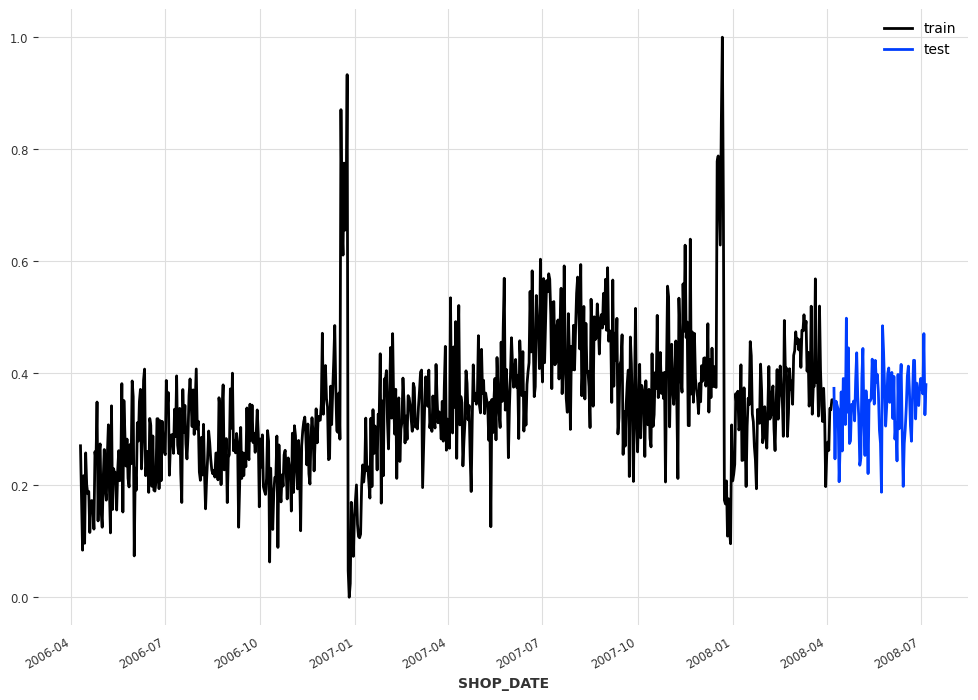

In [279]:
train.plot(label='train')
val.plot(label='test')

In [280]:
# Splitting the data
train_data = series[:-90]
val_data = series[-90:]

In [329]:
def get_trained_nbeats_model(train_data):
    
    time_name = str(int(dt.datetime.now().timestamp()))
    
    model_nbeats = NBEATSModel(
        input_chunk_length=365,
        output_chunk_length=1,
        generic_architecture=True,
        num_stacks=10,
        num_blocks=1,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        nr_epochs_val_period=1,
        batch_size=64,
        model_name=f"nbeats_run_{time_name}",
    )

    # Training the model
    model_nbeats.fit(train_data, verbose=True)
    return model_nbeats

In [330]:
def make_future_predictions_nbeats(model, training_data, look_forward):
    """
    Function to make future predictions.
    """
    predictions = []
    pred_features = np.array(training_data)
    
    for i in range(look_forward):
        # Here, we convert the numpy array to TimeSeries for prediction
        ts_input = TimeSeries.from_values(pred_features)
        next_pred = model.predict(n=1, series=ts_input).last_value()
        predictions.append(next_pred)
        
        pred_features = np.roll(pred_features, shift=-1)
        pred_features[-1] = next_pred
    
    return predictions

In [331]:
def evaluate_nbeats_model(train_X, test_y, scaler):
    
    series = train_X[['TOTAL_SPEND_SCALED']].reset_index()
    series = TimeSeries.from_dataframe(series, time_col='SHOP_DATE')
    train_data = series[:-90]
    
    nbeats_model = get_trained_nbeats_model(train_data)

    nbeats_30 = make_future_predictions_nbeats(nbeats_model, train_data[-365:].values(), 30)
    nbeats_60 = make_future_predictions_nbeats(nbeats_model, train_data[-365:].values(), 60)
    nbeats_90 = make_future_predictions_nbeats(nbeats_model, train_data[-365:].values(), 90)
    
    evaluate_model_predictions(test_y.iloc[:30], 
                               reverse_min_max_scaling(nbeats_30, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y.iloc[:60], 
                               reverse_min_max_scaling(nbeats_60, scaler).reshape(-1,1))
    evaluate_model_predictions(test_y,
                               reverse_min_max_scaling(nbeats_90, scaler).reshape(-1,1))
    
    return nbeats_model, nbeats_30, nbeats_60, nbeats_90

In [332]:
nbeats_model_ss, nbeats_ss_30_s, nbeats_ss_60_s, nbeats_ss_90_s = evaluate_nbeats_model(store_ss, store_ss_ts_pred[1], store_ss_ts_min_max_scaler)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.8 M 
---------------------------------------------------
9.8 M     Trainable params
4.8 K     Non-trainable params
9.8 M     Total params
39.307    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MSE: 230793.12984959187
MAE: 379.34146339462654
RMSE: 480.4093357227687
MSE: 213892.42936913527
MAE: 365.5470460150757
RMSE: 462.48505853609504
MSE: 215713.58060008768
MAE: 363.5139265266584
RMSE: 464.4497611153306


In [333]:
nbeats_model_ms, nbeats_ms_30_s, nbeats_ms_60_s, nbeats_ms_90_s = evaluate_nbeats_model(store_ms, store_ms_ts_pred[1], store_ms_ts_min_max_scaler)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.8 M 
---------------------------------------------------
9.8 M     Trainable params
4.8 K     Non-trainable params
9.8 M     Total params
39.307    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MSE: 1269614.6256719849
MAE: 977.4807787787777
RMSE: 1126.7717717763367
MSE: 1108822.833983759
MAE: 855.0679412594739
RMSE: 1053.0065688227016
MSE: 1023992.7909509498
MAE: 812.3314598949759
RMSE: 1011.9252892140554


In [334]:
nbeats_model_ls, nbeats_ls_30_s, nbeats_ls_60_s, nbeats_ls_90_s = evaluate_nbeats_model(store_ls, store_ls_ts_pred[1], store_ls_ts_min_max_scaler)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.8 M 
---------------------------------------------------
9.8 M     Trainable params
4.8 K     Non-trainable params
9.8 M     Total params
39.307    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MSE: 7031493.188371285
MAE: 2127.732932606933
RMSE: 2651.6962850921077
MSE: 7261365.835250344
MAE: 2196.7995967228712
RMSE: 2694.692159644649
MSE: 7742044.532113519
MAE: 2269.149649113148
RMSE: 2782.4529703327457


In [335]:
nbeats_model_xls, nbeats_xls_30_s, nbeats_xls_60_s, nbeats_xls_90_s = evaluate_nbeats_model(store_xls, store_xls_ts_pred[1], store_xls_ts_min_max_scaler)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.8 M 
---------------------------------------------------
9.8 M     Trainable params
4.8 K     Non-trainable params
9.8 M     Total params
39.307    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MSE: 393492.0477390782
MAE: 457.3217430374562
RMSE: 627.2894449447385
MSE: 424199.6128901814
MAE: 492.9938249547311
RMSE: 651.3060823377757
MSE: 451506.62933608127
MAE: 522.4555775443883
RMSE: 671.942430075733


In [336]:
joblib.dump(nbeats_model_ss, './saved_models/nbeats_model_ss.pkl')
joblib.dump(nbeats_model_ms, './saved_models/nbeats_model_ms.pkl')
joblib.dump(nbeats_model_ls, './saved_models/nbeats_model_ls.pkl')
joblib.dump(nbeats_model_xls, './saved_models/nbeats_model_xls.pkl')

['./saved_models/nbeats_model_xls.pkl']

# N-HiTS 
(still a WIP - would not execute due to package dependencies)  
Ran initally on the Mac but could not resolve the python environment due to dependencies between numpy, sklearn and pytorch-forecasting

In [ ]:
from nbeats_pytorch.model import NBeatsNet
from torch.optim import Adam
import torch

In [ ]:
from darts import TimeSeries
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, BaseModelWithCovariates, TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import RMSE

In [ ]:
# Assuming data is a pandas dataframe with 'time_idx' as time index, 'value' as the target variable and 'group' as an optional group identifier
data = store_ss[['TOTAL_SPEND_SCALED']].reset_index()

# 1. Preprocess the Data
max_prediction_length = 90
max_encoder_length = 365
training_cutoff = data["time_idx"].max() - max_prediction_length

In [ ]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
)

In [ ]:
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)

In [ ]:
train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=128, num_workers=0)

In [ ]:
# 2. Train the Model
trainer = pl.Trainer(max_epochs=10)
model = NHiTS.from_dataset(training, learning_rate=0.1, log_interval=10, log_val_interval=1, hidden_size=64, n_layers=2, n_blocks=[2, 2, 2])
trainer.fit(
    model,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# 3. Make Predictions
raw_predictions, x = model.predict(val_dataloader, mode="raw", return_x=True)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
RMSE()(raw_predictions["prediction"], actuals)

In [ ]:
x_series_s = TimeSeries.from_dataframe(store_ss_ts_pred_scaled[0].reset_index(), time_col='SHOP_DATE')
y_series_s = TimeSeries.from_dataframe(store_ss_ts_pred_scaled[1].reset_index(), time_col='SHOP_DATE')
x_series = TimeSeries.from_dataframe(store_ss_ts_pred[0].reset_index(), time_col='SHOP_DATE')
y_series = TimeSeries.from_dataframe(store_ss_ts_pred[1].reset_index(), time_col='SHOP_DATE')

In [ ]:
x_series.plot(label='train')
y_series.plot(label='test')

In [ ]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=7)
naive_seasonal.fit(x_series)

pred_naive = naive_seasonal.predict(len(y_series))

In [ ]:
y_series.plot(label='test')
pred_naive.plot(label='Baseline')

In [ ]:
from darts.metrics import mae

naive_mae = mae(y_series, pred_naive)

print(naive_mae)

In [ ]:
a = reverse_min_max_scaling(y_series.values(), store_ss_ts_min_max_scaler).reshape(-1,1)
b = reverse_min_max_scaling(pred_naive.values(), store_ss_ts_min_max_scaler).reshape(-1,1)

In [ ]:
evaluate_model_predictions(y_series.values(), pred_naive.values())

In [ ]:
from darts.models import NHiTSModel

In [ ]:
nhits = NHiTSModel(
    input_chunk_length=364, 
    output_chunk_length=1,
    random_state=42)

In [ ]:
nhits.fit(
    x_series_s,
    epochs=50)

In [ ]:
scaled_pred_nhits = nhits.predict(n=90)

In [ ]:
pred_nhits = reverse_min_max_scaling(scaled_pred_nhits.values(), store_ss_ts_min_max_scaler).reshape(-1,1)

In [ ]:
evaluate_model_predictions(pred_nhits, y_series.values())

In [ ]:
y_series_s.plot(label='Actual')
scaled_pred_nhits.plot(label='N-HiTS')